# Объедненный код Team-4

# Задача

Подробнее об условии задачи

Имеется неизвестный нам алгоритм по объединению заказов и результат его работы на выборке ресторанов А. В задаче нужно предсказать поведение алгоритма на выборке ресторанов B. Скачать данные можно на странице с описанием задачи, в формате .xlsx. Это не привычный нам по курсу формат .csv, и смена расширения на .csv здесь не сработает. Поэтому первым делом вам нужно найти способ загрузить эти данные в Python. Рассмотрим по очереди, что означает каждый столбец.

brand_name. Это и есть выборка ресторанов (А или В). Все строки с brand_name == А - это реальные обезличенные данные о заказах в Яндекс Еде, при этом работал алгоритм, объединяющий некоторые заказы (не более двух!). Все строки с brand_name == В - это тоже реальные данные о заказах, но в других ресторанах, для которых алгоритм объдинения заказов не работал. Ваша задача - предсказать, какой процент заказов был бы объединен, если бы работал алгоритм объединения. Например, если у нас всего 3 заказа, и первый объединен со вторым, то объединено 66.7% заказов.

rest_id. Идентификатор конкретного ресторана (то есть конкретного адреса, откуда курьер забирает заказ). Заказы могут объединяться только если у них один и тот же rest_id.

order_id. Уникальный идентификатор заказа.

batched_with_order_id. Идентификатор заказа, объединенного с текущим (при наличии). Очевидно, что в выборке В это поле всегда пусто.

first_in_multiorder_flg. Является ли заказ первым в мультизаказе (при объединении двух заказов).

courier_id. Уникальный идентификатор курьера.

order_items_cnt. Количество позиций в заказе.

city. Уникальный идентификатор города. Все заказы выборки А принадлежат одному и тому же городу, а вот в выборке В есть разные города.

order_created_datetime. Время создания заказа. Обратите внимание, указан 2015 год, но это не значит, что задача старая. Дело в том, что данные обезличены, и все даты тоже изменены.

In [10]:
'''Функция get_part_multiorders  -  получает датасет группы ресторанов и возвращает значение доли мультизаказов'''
def get_part_multiorders(df):
    # df - Датасет группы А или группы В
    # df_batched - объединенные заказы в группе
    df_batched = df[df.batched_with_order_id.str.contains('',na=False)]
    # count -кол-во всех заказов
    count = len(df)
    # count_batched - кол-во объединенных заказов
    count_batched = len(df_batched)
    eps_batched = 100*count_batched/count
    return eps_batched


'''Функция set_hms_to_df добавляет колонки часа, минут и секунд создания заказа к датафрейму df'''
def set_hms_to_df(df):
    h = []
    m = []
    s = []
    df.order_created_datetime = pd.to_datetime(df.order_created_datetime)
    for d in df.order_created_datetime: #временный массив  часов
        h.append(d.hour)
        m.append(d.minute)
        s.append(d.second)
    df_hms=pd.DataFrame({'order_id':df.order_id,'hour_order':h,'minute_order':m,'second_order':s})
    merged_df = df.merge(df_hms, left_on='order_id', right_on='order_id', how='inner')
    return merged_df

'''Функция поиска парных заказов в датафреймах'''
def count_pair_orders(df_a_not_batched):
    # создадим цикл ресторан->курьер, который выводит раздельные датасеты с информацией о количестве и времени создания заказа
    #deltat - переменная равная 40 минутам - принятая максимальная разница между временем создания объединенных заказов
    from datetime import timedelta
    deltat = timedelta(days = 0, seconds = 0, microseconds=0, milliseconds=0, minutes=40,hours=0, weeks=0)

    #добавим колонки часа, минут и секунд
    df_a_not_batched2 = set_hms_to_df(df_a_not_batched)
    #заказы только в рабочее время c 8:00 до 22:59
    df_a_not_batched2 = df_a_not_batched2[(df_a_not_batched2['hour_order'] >=8) & (df_a_not_batched2['hour_order'] <= 22)]
    # сортируем по времени
    df_a_not_batched2 = df_a_not_batched2.sort_values(by='order_created_datetime')

    counts_all = 0
    for city in df_a_not_batched2.city.unique():
#         print('city ', city)
        count_city = 0
        for rest_id in df_a_not_batched2[(df_a_not_batched2.city == city)].rest_id.unique():
#             print('rest_id ', rest_id)
            count_rest = 0
            for courier_id in df_a_not_batched2[(df_a_not_batched2.city == city)& (df_a_not_batched2.rest_id == rest_id)].courier_id.unique():
#                 print('courier_id ', courier_id)
                count_courier = 0
                df_term = df_a_not_batched2[(df_a_not_batched2.city == city) & (df_a_not_batched2.rest_id == rest_id) & (df_a_not_batched2.courier_id == courier_id)]
                if len(df_term) > 1:
                    # сравниваем с единицей, так как датасет с единственным заказом нас не интересует, для него все равно пары нет
                    # получаем сериес со списком разниц по времени между соседними заказами
                    delta_times = abs(pd.to_datetime(df_term.order_created_datetime) - pd.to_datetime(df_term.order_created_datetime.shift()))
                    #is_skiped - пропускать или нет
                    is_skiped = False
                    ind = 0
                    # присваиваем индексы сириеса в переменную
                    inds_d = delta_times.index
                    # идем по дельтам
                    # deltat - 40 мин.
                    for d_item in delta_times:
                        if d_item<deltat:
                            #нужно пропустить следующую пару, так как в ней участвует один из текущих заказов
                            if is_skiped:
                                is_skiped = False
                                continue
                            is_skiped = False
#                             display(df_term.iloc[[ind-1, ind], [0,1,2,3,4,5,6,7,8]])
                            counts_all += 1
                            count_rest += 1
                            count_courier +=1
                            count_city += 1
                            is_skiped = True #нужно пропустить следующую пару, так как в ней участвует один из текущих заказов
                        ind += 1 
#                     print('кол-во объединенных пар по курьеру:', count_courier)
#             print('кол-во объединенных пар по ресторану:', count_rest)
#         print('кол-во объединенных пар по городу:', count_city)
    print('количество объединенных пар всего:', counts_all)
    return counts_all



In [16]:
# Загружаем библиотеки
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
%matplotlib inline
from datetime import datetime
# Загружаем exel файл
df = pd.read_excel('yandex_hack.xlsx')

# Разделим датафрейм на выборки ресторанов A и B
# df_a - датафрейм с выборкой ресторанов A
# df_b - датафрейм с выборкой ресторанов B
df_a = df[df.brand_name == 'A'] 
df_b = df[df.brand_name == 'B'] 

# выясняем долю мультизаказов в группе ресторанов А
eps_batched_A = get_part_multiorders(df_a[df_a.city == 'e6705560085199e9674cd721ee844d0d'])
print('Доля заказов в группе ресторанов А =', round(eps_batched_A,2), '%')

Доля заказов в группе ресторанов А = 9.06 %


## Подзадача 1:
Выяснить принцип, по которому алгоритм объединяет заказы в мультизаказы в группе ресторанов А. Для этого
1. Получим таблицу объединенных заказов (из исходного  датасета выберем заказы ресторанов А, получим df_A, и уберем не объединенные заказы)
2. Проверим гипотезу, что заказы объединяются только для одного курьера, города, ресторана
3. Проверим гипотезу, что существует максимальная разница во времени между созданием двух объединенных заказов.
4. Проверим гипотезу, что заказы ограничены по суммарному количеству пунктов в мультизаказе
5. Построим гистограммы, чтобы обосновать свою теорию

In [17]:
#Получим таблицу объединенных заказов 
#(из исходного датасета выберем заказы ресторанов А, получим df_A, и уберем не объединенные заказы)
df_a_batched = df_a[df_a.batched_with_order_id.str.contains('',na=False)]
display(df_a_batched.head())
print('Всего объединенных заказов в группе А:', len(df_a_batched))

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
257,2015-09-13 17:37:08.000000,A,8da96a16838351f6f096d45a4e159f4d,89164b34e9d20a1c1918d156ca7c2b1e,9f8fb710b29202ac3dc36a6712186de4,0.0,2644231e976679c41b15a11524a4e530,8,e6705560085199e9674cd721ee844d0d
435,2015-09-13 11:18:49.000000,A,b3bf2fc20c4646298c05716fbe1aa135,afc4c403cc654734538b007fdbc87664,d887b9731cf06e5dd77623ef5ad56cd8,0.0,8632dc891885aba8e572522dedc7572f,3,e6705560085199e9674cd721ee844d0d
526,2015-09-15 11:55:03.000000,A,2acb4a3db77b139dda1cd6bcbbfd4b8e,986941e665d646910d432b5f48f9b94c,fd0dde82caff2d709ac803c8872fd1e9,0.0,7e8de661602e618fe8cb16c8b3e02a95,3,e6705560085199e9674cd721ee844d0d
684,2015-09-15 17:36:03.000000,A,525505123c94df09ef5b5614e4afe7b2,d469fe73826b9b3f1a3ee58869d91757,b4e39b3e84e81f1ea34c353896ff6853,0.0,876e5276f463736bf52fc540664fd02e,5,e6705560085199e9674cd721ee844d0d
717,2015-09-13 17:08:07.000000,A,680fee36fb26805d3bf7af52cdb44f0f,831b2771564b022030ce699e6807ab03,6efbee90330a0bced1f7938a2e209054,0.0,8a2d57b71452eed5c78c3f81ee2999d2,3,e6705560085199e9674cd721ee844d0d


Всего объединенных заказов в группе А: 442


In [61]:
# составим датафрейм, где каждая строка - это пара объединенных заказов
# df_a_batched_first - первые заказы в паре объединенных заказов
df_a_batched_first = df_a_batched[df_a_batched.first_in_multiorder_flg == 1]
# df_a_batched_second - вторые заказы в паре объединенных заказов
df_a_batched_second = df_a_batched[df_a_batched.first_in_multiorder_flg == 0]
df_a_pairs = df_a_batched_first.merge(df_a_batched_second, left_on='batched_with_order_id', right_on='order_id', how ='inner')
# df_a_pairs - столбцы с суффиксом _x - значения первого заказа,с суффиксом _y - значения второго заказа
display(df_a_pairs)
print('Всего ПАР объединенных заказов в группе А:', len(df_a_pairs))

,order_created_datetime_x,brand_name_x,rest_id_x,batched_with_order_id_x,order_id_x,first_in_multiorder_flg_x,courier_id_x,order_items_cnt_x,city_x,order_created_datetime_y,brand_name_y,rest_id_y,batched_with_order_id_y,order_id_y,first_in_multiorder_flg_y,courier_id_y,order_items_cnt_y,city_y
0,2015-09-13 13:31:28.000000,A,4f67f63ef20bd9541e8e98c62a41adc8,2506b51ec60ce15683b6540373d7c9c2,9bea4d0806522ef428a993464dfe2cd5,1.0,d20b6cce1fbd76c75192555d083fae2c,1,e6705560085199e9674cd721ee844d0d,2015-09-13 13:19:12.000000,A,4f67f63ef20bd9541e8e98c62a41adc8,9bea4d0806522ef428a993464dfe2cd5,2506b51ec60ce15683b6540373d7c9c2,0.0,d20b6cce1fbd76c75192555d083fae2c,4,e6705560085199e9674cd721ee844d0d
1,2015-09-14 21:12:12.000000,A,9b73035bb90cd7de4b9c1ff01e44f178,10f036a70924178cfb5ee762da4c56c2,f33fc1f670f4150526faa1291816158f,1.0,5727e75f0b8020acad71f318cfb9e90b,5,e6705560085199e9674cd721ee844d0d,2015-09-14 21:08:15.000000,A,9b73035bb90cd7de4b9c1ff01e44f178,f33fc1f670f4150526faa1291816158f,10f036a70924178cfb5ee762da4c56c2,0.0,5727e75f0b8020acad71f318cfb9e90b,3,e6705560085199e9674cd721ee844d0d
2,2015-09-14 23:11:07.000000,A,b3bf2fc20c4646298c05716fbe1aa135,a91a73cc77884c0c594d0a600aa0fe5b,0e0984a5a2019591d54af8bde172e75b,1.0,d41ff061323280cf0cebd9adb7a0755e,5,e6705560085199e9674cd721ee844d0d,2015-09-14 23:25:22.000000,A,b3bf2fc20c4646298c05716fbe1aa135,0e0984a5a2019591d54af8bde172e75b,a91a73cc77884c0c594d0a600aa0fe5b,0.0,d41ff061323280cf0cebd9adb7a0755e,5,e6705560085199e9674cd721ee844d0d
3,2015-09-13 22:13:15.000000,A,bc88b0650a748b43b1d6a2d5e7460331,a445ec281209e49a121c9ef3c8ca5aeb,3372ba11de75d1bb8d463268051d8090,1.0,285c3c5407bc05609cd4616296aaea83,6,e6705560085199e9674cd721ee844d0d,2015-09-13 22:10:31.000000,A,bc88b0650a748b43b1d6a2d5e7460331,3372ba11de75d1bb8d463268051d8090,a445ec281209e49a121c9ef3c8ca5aeb,0.0,285c3c5407bc05609cd4616296aaea83,5,e6705560085199e9674cd721ee844d0d
4,2015-09-13 18:20:47.000000,A,3b83cec768ee9456b59a8051ead1c6fb,0ea5b6c8a1034d60c089c8fa2335194f,5b6d9050e4ce7c496c387bd2a64b7921,1.0,5507a0f34faeb458294cc35f6fde1071,2,e6705560085199e9674cd721ee844d0d,2015-09-13 18:27:51.000000,A,3b83cec768ee9456b59a8051ead1c6fb,5b6d9050e4ce7c496c387bd2a64b7921,0ea5b6c8a1034d60c089c8fa2335194f,0.0,5507a0f34faeb458294cc35f6fde1071,2,e6705560085199e9674cd721ee844d0d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2015-09-15 20:52:00.000000,A,304c5a352ef5a8a99017e4c2b222dd2b,b6f424bafa97c132953d3a867f961b41,970a6e3825fad425d4ead2537ba3e5ba,1.0,05cc25f8e2c52cced489ee3dd040ec18,4,e6705560085199e9674cd721ee844d0d,2015-09-15 20:59:18.000000,A,304c5a352ef5a8a99017e4c2b222dd2b,970a6e3825fad425d4ead2537ba3e5ba,b6f424bafa97c132953d3a867f961b41,0.0,05cc25f8e2c52cced489ee3dd040ec18,6,e6705560085199e9674cd721ee844d0d
217,2015-09-15 18:59:48.000000,A,67dad1e37306316763668dce80f111ed,b39db8b30bd9c0fa8aae775403130d40,1e57af3ca8dbfca2a402580dbfd3cc94,1.0,31aae7ec1afba15c0595972127c15c73,4,e6705560085199e9674cd721ee844d0d,2015-09-15 19:01:56.000000,A,67dad1e37306316763668dce80f111ed,1e57af3ca8dbfca2a402580dbfd3cc94,b39db8b30bd9c0fa8aae775403130d40,0.0,31aae7ec1afba15c0595972127c15c73,2,e6705560085199e9674cd721ee844d0d
218,2015-09-15 21:10:26.000000,A,209e34a1614d9469fddabc7158003653,75f2144012c89ff38d64528249a3b66a,1615d55a81b7c68f292c381146cfd30f,1.0,f3f94fe6582fc6ac052af9a8ff384a2e,2,e6705560085199e9674cd721ee844d0d,2015-09-15 21:17:16.000000,A,209e34a1614d9469fddabc7158003653,1615d55a81b7c68f292c381146cfd30f,75f2144012c89ff38d64528249a3b66a,0.0,f3f94fe6582fc6ac052af9a8ff384a2e,4,e6705560085199e9674cd721ee844d0d
219,2015-09-14 14:40:35.000000,A,974d115d8040e56fcac9638bd33e1731,bdb29739e550cd9bce8d0b2e07b6f33b,759928f3b5075cf0eea68cc97d17cf06,1.0,88750b500f3f628d7d85b352f6113736,2,e6705560085199e9674cd721ee844d0d,2015-09-14 14:35:20.000000,A,974d115d8040e56fcac9638bd33e1731,759928f3b5075cf0eea68cc97d17cf06,bdb29739e550cd9bce8d0b2e07b6f33b,0.0,88750b500f3f628d7d85b352f6113736,7,e6705560085199e9674cd721ee844d0d


Всего ПАР объединенных заказов в группе А: 221


# Исследуем таблицу  df_a_pairs. Проверим гипотезу из Подзадачи 1:
Проверим гипотизу, что заказы объединяются только для одного курьера, города

Введем условия, что:

rest_id_x == rest_id_y, 

courier_id_x == courier_id_y

city_x == city_y

Если количество пар после этого не уменьшится, то считаем гипотезу подтвержденной.

In [62]:
if len(df_a_pairs) == (len(df_a_pairs[(df_a_pairs.rest_id_x == df_a_pairs.rest_id_y) 
                                      & (df_a_pairs.courier_id_x == df_a_pairs.courier_id_y) 
                                      & (df_a_pairs.city_x == df_a_pairs.city_y)])):
    print('Количество пар не изменилось, гипотеза верна')
else:
    print('Количествр пар изменилось, датасет требует дальнейшего исследования по изучаемым параметрам')

Количество пар не изменилось, гипотеза верна


# Гипотеза ВЕРНА!

## Исследуем следующую гипотезу:
Проверим гипотезу, что существует максимальная разница во времени между созданием двух объединенных заказов.

Для того очистим таблицу от проверенных столбцов, оставим только order_id, order_created_datetime, order_items_cnt

К полученной таблице добавим столбец delta_datetime, в котором будет содержаться разница по времени между заказами.
Построим гистограмму.

Если будет какая-то теория, проверим, что она не работает на не объелиненных заказах

In [63]:
df_a_pairs_pure = df_a_pairs.drop(columns=['brand_name_x', 'brand_name_y', 'rest_id_x', 'rest_id_y', 
                                      'courier_id_x', 'courier_id_y', 'city_x', 'city_y', 
                                           'batched_with_order_id_x', 'batched_with_order_id_y',
                                          'first_in_multiorder_flg_x', 'first_in_multiorder_flg_y'])
#приведем столбцы с датами к типу datetime
df_a_pairs_pure.order_created_datetime_x = pd.to_datetime(df_a_pairs_pure.order_created_datetime_x)
df_a_pairs_pure.order_created_datetime_y = pd.to_datetime(df_a_pairs_pure.order_created_datetime_y)

ser_delta_datetimes = abs(df_a_pairs_pure.order_created_datetime_y - df_a_pairs_pure.order_created_datetime_x)
ser_sum_items = df_a_pairs_pure.order_items_cnt_x + df_a_pairs_pure.order_items_cnt_y

df_a_pairs_full = pd.concat([df_a_pairs_pure, ser_delta_datetimes.rename('delta_datetime'), ser_sum_items.rename('sum_items')], axis=1, sort=False)

# поменяем порядок столбцов
cols = ['order_id_x', 'order_id_y', 'order_created_datetime_x', 'order_created_datetime_y', 'delta_datetime', 'order_items_cnt_x', 'order_items_cnt_y', 'sum_items']
df_a_pairs_full = df_a_pairs_full[cols]

#отсортируем таблицу по разнице во времени заказов delta_datetime
display(df_a_pairs_full.sort_values(by='delta_datetime'))
#отсортируем таблицу по количеству пунктов в заказе
display(df_a_pairs_full.sort_values(by='sum_items'))

,order_id_x,order_id_y,order_created_datetime_x,order_created_datetime_y,delta_datetime,order_items_cnt_x,order_items_cnt_y,sum_items
45,96d81106cf55de141265047419cb9f08,452e095b7ebc7da1ab7ec95f6a9f540f,2015-09-15 18:32:34,2015-09-15 18:32:32,00:00:02,1,4,5
179,a95b131e7eb2cee635121fdd9075a8c5,4b3cca487c23cadc2b9fcb8c0e9c462b,2015-09-13 20:17:49,2015-09-13 20:17:43,00:00:06,3,6,9
202,92b806f231ddc38f8d30b430f8980c62,12f39578354d499d0e7eb57787b78863,2015-09-13 19:37:17,2015-09-13 19:37:27,00:00:10,5,5,10
143,bd47ae55e517a404ae1491b8dec7baf2,60a60dd8dd27218daec3f1062e7427ca,2015-09-15 18:23:21,2015-09-15 18:23:11,00:00:10,3,6,9
11,d6ae7988db37d62e2fd4ac623370490f,21c3e762247c859994dc358d705d0b48,2015-09-15 19:13:09,2015-09-15 19:12:59,00:00:10,5,3,8
...,...,...,...,...,...,...,...,...
170,40b56e9800ab13da575a6cd0ca357ffd,41ae0a47d0ac5a66031741512e4950a4,2015-09-13 15:56:54,2015-09-13 15:35:39,00:21:15,3,5,8
200,38114f43b317b925c2847f8d79e41d3f,6bb625c0e2367ef40b1cf2a7458195cc,2015-09-13 19:16:23,2015-09-13 19:38:50,00:22:27,13,4,17
207,ced5e31294eca5cc4b507b660e7ce7fc,501a7316c89b70a8c72f1f4a77b7372a,2015-09-13 19:01:51,2015-09-13 19:24:28,00:22:37,12,3,15
21,ee7e42b16b99356332c3466e0b4b10c6,964af6fb6a5f44ec3de1f8e122ad2074,2015-09-15 10:01:31,2015-09-15 10:36:03,00:34:32,3,5,8


,order_id_x,order_id_y,order_created_datetime_x,order_created_datetime_y,delta_datetime,order_items_cnt_x,order_items_cnt_y,sum_items
69,e70f6d87632ec8f62908b710321b224a,4983db048d2503aa1d4bd1b802a20506,2015-09-15 22:37:12,2015-09-15 22:31:44,00:05:28,1,1,2
22,0e47651e92bc95d80339b5bbc1ed116a,90cad25f789ef1ba65e1438902f1caf0,2015-09-14 17:39:49,2015-09-14 17:31:13,00:08:36,1,2,3
215,ea0396cf4cf7ad349e566b87377c7f91,b0252f9086b9bfd7b11b1088fe4a0cc7,2015-09-14 21:01:33,2015-09-14 21:05:17,00:03:44,2,1,3
190,3f7ddf8c010b73bdd69e25d8f327bb9f,7997698ea410a143de852924b3be553a,2015-09-15 16:44:52,2015-09-15 16:37:58,00:06:54,2,1,3
13,019f700fcf55b62d2b99a880bb62f1a9,e18ae5ac48d697020ca33ad9cc62f4b1,2015-09-13 20:33:32,2015-09-13 20:28:47,00:04:45,2,2,4
...,...,...,...,...,...,...,...,...
71,8bd02e0f951c48857fdcc48931793f58,682c7901612d0d865c7fd02889aa8c67,2015-09-13 18:07:59,2015-09-13 18:15:53,00:07:54,6,15,21
180,b9527e1826aef3cbca66baba50eacdb5,336c556952920afa0922d0a928d066d0,2015-09-13 15:29:35,2015-09-13 15:28:57,00:00:38,13,9,22
58,55d654c76aae9ff0568d18f639a3ad36,f9f3e78da7d43882c9ca35e3bf2bf28e,2015-09-15 21:11:38,2015-09-15 21:18:05,00:06:27,8,15,23
157,342bd95202383b71d74d949c2ba4618f,1b9948e40c86806b76361246a0718e40,2015-09-14 10:14:48,2015-09-14 10:20:56,00:06:08,10,16,26


# Выводы

## По времени создания
Отфильтровав объединенные заказы по показателю дельты времени создания заказов мультизаказа, мы определили, что максимальная дельта составляет 8 часов 39 минут, а предыдущее по величене значение 34 минуты 32 сек.

Если подробно посмотреть на пару заказов с разностью 8 часов 39 минут, мы увидим, что первый заказ сделан в 4 утра, а второй в 12 часов 39 минут. Предполагаем, что человек оформил этот заказ к определенному времени, например после 12:00. Таким образом разница между ними была бы около 40 минут.

## По позициям
Максимальное число позиций в одном мультизаказе 27



[2, 6, 10, 10, 10, 12, 15, 18, 24, 30, 34, 38, 38, 39, 42, 44, 46, 47, 52, 59, 60, 72, 72, 75, 77, 79, 82, 93, 94, 98, 99, 99, 104, 108, 109, 113, 120, 124, 126, 128, 140, 148, 149, 155, 155, 155, 159, 163, 164, 164, 165, 166, 168, 172, 173, 176, 180, 180, 194, 194, 194, 198, 198, 201, 204, 208, 211, 223, 224, 225, 230, 237, 239, 241, 242, 248, 248, 252, 252, 258, 263, 265, 266, 266, 272, 272, 276, 278, 279, 281, 285, 287, 292, 293, 306, 313, 315, 327, 328, 329, 329, 330, 331, 332, 333, 336, 340, 356, 358, 363, 364, 365, 368, 374, 387, 388, 393, 402, 405, 406, 410, 410, 410, 414, 415, 424, 429, 431, 436, 438, 443, 447, 448, 460, 467, 470, 474, 477, 479, 481, 481, 487, 488, 503, 505, 514, 515, 516, 518, 520, 530, 535, 537, 538, 541, 547, 547, 547, 548, 550, 551, 560, 567, 576, 578, 579, 589, 598, 599, 603, 603, 607, 617, 618, 630, 638, 642, 644, 650, 653, 661, 663, 670, 678, 694, 699, 703, 724, 726, 735, 736, 763, 768, 784, 787, 788, 797, 804, 810, 814, 830, 833, 855, 868, 875, 912, 949

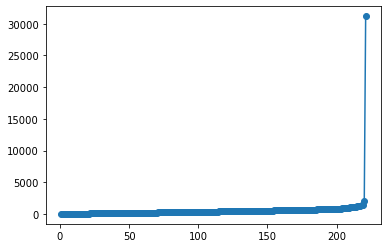

In [95]:
# Построим графики для наглядности

# разница во времени между заказами в мультизаказе
# переводим в секунды и создаем список с секундами seconds_list(ось y), с количеством x(ось х)
seconds_list = []
x = []
i = 0
for d in df_a_pairs_full['delta_datetime'].sort_values():
    i +=1
    seconds_list.append(d.seconds)
    x.append(i)
plt.plot(x,seconds_list, marker='o')
print(seconds_list)


В выборке есть один выброс - мультизаказ с разницей во времени 08:39:48	 = 31188 сек

# Важно:
Предположение: Разница между временем создания двух совмещенных заказов не более 35-40 минут.

Text(0.5, 0, 'Кол-во позиций в мульти-заказе')

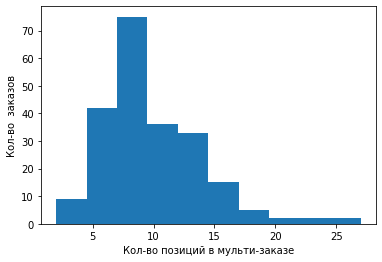

In [94]:
# график частоты заказов по суммарному количеству позиций в мультизаказе
df_a_pairs_full['sum_items'].plot(kind = 'hist')
plt.ylabel('Кол-во  заказов')
plt.xlabel('Кол-во позиций в мульти-заказе')


# Выводы

#в основном мультизаказ насчитывает от 5 до 13 позиций

# Изучим выборку по времени подробнее

In [97]:
df_time = df_a_pairs_full.sort_values(by='delta_datetime')
df_time

,order_id_x,order_id_y,order_created_datetime_x,order_created_datetime_y,delta_datetime,order_items_cnt_x,order_items_cnt_y,sum_items
45,96d81106cf55de141265047419cb9f08,452e095b7ebc7da1ab7ec95f6a9f540f,2015-09-15 18:32:34,2015-09-15 18:32:32,00:00:02,1,4,5
179,a95b131e7eb2cee635121fdd9075a8c5,4b3cca487c23cadc2b9fcb8c0e9c462b,2015-09-13 20:17:49,2015-09-13 20:17:43,00:00:06,3,6,9
202,92b806f231ddc38f8d30b430f8980c62,12f39578354d499d0e7eb57787b78863,2015-09-13 19:37:17,2015-09-13 19:37:27,00:00:10,5,5,10
143,bd47ae55e517a404ae1491b8dec7baf2,60a60dd8dd27218daec3f1062e7427ca,2015-09-15 18:23:21,2015-09-15 18:23:11,00:00:10,3,6,9
11,d6ae7988db37d62e2fd4ac623370490f,21c3e762247c859994dc358d705d0b48,2015-09-15 19:13:09,2015-09-15 19:12:59,00:00:10,5,3,8
...,...,...,...,...,...,...,...,...
170,40b56e9800ab13da575a6cd0ca357ffd,41ae0a47d0ac5a66031741512e4950a4,2015-09-13 15:56:54,2015-09-13 15:35:39,00:21:15,3,5,8
200,38114f43b317b925c2847f8d79e41d3f,6bb625c0e2367ef40b1cf2a7458195cc,2015-09-13 19:16:23,2015-09-13 19:38:50,00:22:27,13,4,17
207,ced5e31294eca5cc4b507b660e7ce7fc,501a7316c89b70a8c72f1f4a77b7372a,2015-09-13 19:01:51,2015-09-13 19:24:28,00:22:37,12,3,15
21,ee7e42b16b99356332c3466e0b4b10c6,964af6fb6a5f44ec3de1f8e122ad2074,2015-09-15 10:01:31,2015-09-15 10:36:03,00:34:32,3,5,8


В мультизаказе, который считаем "выбросом", один из заказов сделан ночью.

In [99]:
#при просмотре дельты времени между заказами, объединенными в 1 мультизаказ - обнаружился 1 случай, в котором разница между заказами составила 8 часов - это мог быть случай, когда человек сделал заказ к определенному времени (оформлен ночью, а желаемая дата доставки оказалась после открытия ресторана и совпала с размещенным вторым заказом)
#либо это ошибка
#один заказ оформили ночью в 4 утра к определенному времени, видимо ресторан открылся в 12, и второй заказ упал в 12:39 и поэтому их объединили
#предположим, что максимальное время между заказами 40 мин в рамках режима работы ресторана

df_time.loc[168]

order_id_x                  d0febfc6653fa848cf0a9fadf98261dd
order_id_y                  931ad84269827a4c27ce66734460cdf7
order_created_datetime_x                 2015-09-13 12:39:59
order_created_datetime_y                 2015-09-13 04:00:11
delta_datetime                               0 days 08:39:48
order_items_cnt_x                                          3
order_items_cnt_y                                          7
sum_items                                                 10
Name: 168, dtype: object

In [100]:
# исключаем выброс
df_time=df_time.drop([168])

oY [2, 6, 10, 10, 10, 12, 15, 18, 24, 30, 34, 38, 38, 39, 42, 44, 46, 47, 52, 59, 60, 72, 72, 75, 77, 79, 82, 93, 94, 98, 99, 99, 104, 108, 109, 113, 120, 124, 126, 128, 140, 148, 149, 155, 155, 155, 159, 163, 164, 164, 165, 166, 168, 172, 173, 176, 180, 180, 194, 194, 194, 198, 198, 201, 204, 208, 211, 223, 224, 225, 230, 237, 239, 241, 242, 248, 248, 252, 252, 258, 263, 265, 266, 266, 272, 272, 276, 278, 279, 281, 285, 287, 292, 293, 306, 313, 315, 327, 328, 329, 329, 330, 331, 332, 333, 336, 340, 356, 358, 363, 364, 365, 368, 374, 387, 388, 393, 402, 405, 406, 410, 410, 410, 414, 415, 424, 429, 431, 436, 438, 443, 447, 448, 460, 467, 470, 474, 477, 479, 481, 481, 487, 488, 503, 505, 514, 515, 516, 518, 520, 530, 535, 537, 538, 541, 547, 547, 547, 548, 550, 551, 560, 567, 576, 578, 579, 589, 598, 599, 603, 603, 607, 617, 618, 630, 638, 642, 644, 650, 653, 661, 663, 670, 678, 694, 699, 703, 724, 726, 735, 736, 763, 768, 784, 787, 788, 797, 804, 810, 814, 830, 833, 855, 868, 875, 912, 

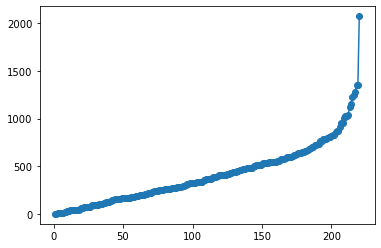

In [102]:
#  разница во времени между заказами объединенными
seconds_list = []
x = []
i = 0
for d in df_time['delta_datetime'].sort_values():
    i +=1
    seconds_list.append(d.seconds)
    x.append(i)
plt.plot(x,seconds_list, marker='o')
print('oY',seconds_list)

In [104]:
#средняя дельта во времени между двумя объединенными заказами - 7 мин (7*60=420сек)
df_time.delta_datetime.mean()

Timedelta('0 days 00:06:56.477272')

In [105]:
#медианная дельта во времени между двумя объединенными заказами - 6 мин
df_time.delta_datetime.median()

Timedelta('0 days 00:06:03.500000')

# Основной вывод
#предположим, что максимальное время между заказами 40 мин в рамках режима работы ресторана

# Исследуем не объединенные заказы гр.А

В необъединенных заказах смотрим только город 'e6705560085199e9674cd721ee844d0d', так как только в нем есть объединенные заказы, а значит (из условий задачи), что на другие города алгоритм не применялся


In [289]:
# Исследуем время не объединенных заказов гр.А
df_a_not_batched = df_a[(~df_a.batched_with_order_id.str.contains('',na=False)) & (df_a.city == 'e6705560085199e9674cd721ee844d0d')]
df_a_not_batched.order_created_datetime = pd.to_datetime(df_a_not_batched.order_created_datetime)
df_a_not_batched = df_a_not_batched.sort_values(by ='order_created_datetime')
df_a_not_batched

C:\Users\TANYA\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
64367,2015-09-13 00:00:05,A,d1e66c75e8deec66a0aa08aefa5736aa,NaN,ffc6ecf37c8391821bda9111320f299c,NaN,d016782f2092ef2b2f943e736ececced,2,e6705560085199e9674cd721ee844d0d
58676,2015-09-13 00:00:13,A,39baa0eae83853d736e398093239dcd5,NaN,49d061c7882d839710443d8ac8108d7e,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d
11760,2015-09-13 00:00:39,A,d1e66c75e8deec66a0aa08aefa5736aa,NaN,3e293d204168757552ebd7b62ea38889,NaN,d016782f2092ef2b2f943e736ececced,10,e6705560085199e9674cd721ee844d0d
61748,2015-09-13 00:00:59,A,7fc42db5411a27043847b4ab8aa7a5a1,NaN,b4bd74ec8d2f492f305eb70c90c3fce5,NaN,d016782f2092ef2b2f943e736ececced,13,e6705560085199e9674cd721ee844d0d
56702,2015-09-13 00:01:44,A,3b83cec768ee9456b59a8051ead1c6fb,NaN,e656c891f5ee182b266b7def80ad70ae,NaN,d016782f2092ef2b2f943e736ececced,6,e6705560085199e9674cd721ee844d0d
...,...,...,...,...,...,...,...,...,...
41860,2015-09-16 10:51:31,A,9c133e3302df8a1ab0ad613a8ca2e4cd,NaN,8efb72bee82ba38e659c2dd3bdda416f,NaN,9ee61d2bf11b130bddc2eaf65fe486d4,9,e6705560085199e9674cd721ee844d0d
29089,2015-09-16 10:51:39,A,0ab71472311f386e7a527450a2912840,NaN,f0804e496bca27952a93a3c0c1abbb27,NaN,591bf8687415c2b68b961241943886f4,3,e6705560085199e9674cd721ee844d0d
23788,2015-09-16 10:52:04,A,707f1da36335ef7234721b49991d39c3,NaN,af30e054f400619c904b369050333b53,NaN,cd30a21c6bbbcc784de70aa8627be584,2,e6705560085199e9674cd721ee844d0d
62591,2015-09-16 10:55:15,A,d96c27c8d8e2c7e386dd0cf79735df64,NaN,9da68e182b2585afa1bb442c00c7b568,NaN,3c451a2f8eff73da6e19c4de4d470bab,2,e6705560085199e9674cd721ee844d0d


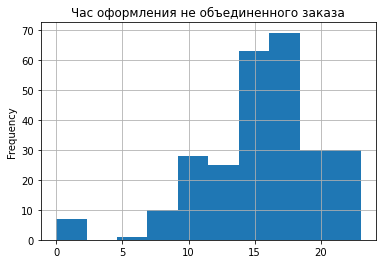

In [166]:
hours = [d.hour for d in df_a_not_batched.order_created_datetime]
minutes = [d.minute for d in df_a_not_batched.order_created_datetime]
seconds = [d.second for d in df_a_not_batched.order_created_datetime]
# print(hours,minutes,seconds)

dfTime=pd.DataFrame(hours, columns=['Hours'])
df_a_not_batched['Hours']=dfTime
df_a_not_batched['Hours'].plot(kind = 'hist', grid = True, title = 'Час оформления не объединенного заказа')

#объединенные заказы размещались примерно с 8 утра до 23:00 ночи


# # построим график по времени заказа, ось Y в секундах
# seconds_list = []
# x = []
# i = 0
# for d in df_a_not_batched['order_created_datetime'].sort_values():
#     i +=1
#     seconds_list.append(d)
#     x.append(i)
# plt.plot(seconds_list, x, marker='o')
# # print('oY',seconds_list)

Text(0.5, 0, 'Кол-во позиций в не объединенном заказе')

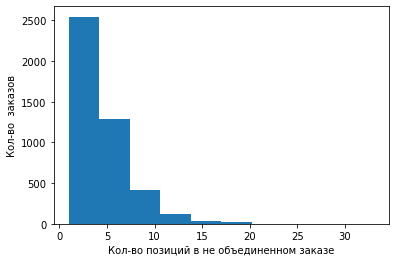

In [167]:
# график частоты заказов по количество позиций в необъединенных заказах
df_a_not_batched['order_items_cnt'].plot(kind = 'hist')
plt.ylabel('Кол-во  заказов')
plt.xlabel('Кол-во позиций в не объединенном заказе')


Text(0.5, 0, 'Кол-во позиций в объединенном заказе')

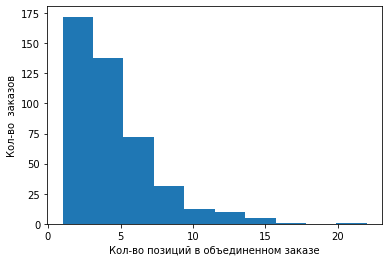

In [144]:
df_a_batched['order_items_cnt'].plot(kind = 'hist')
plt.ylabel('Кол-во  заказов')
plt.xlabel('Кол-во позиций в объединенном заказе')

In [302]:
# создадим цикл ресторан->курьер, который выводит раздельные датасеты с информацией о количестве и времени создания заказа
#deltat - переменная равная 40 минутам - принятая максимальная разница между временем создания объединенных заказов
from datetime import timedelta
deltat = timedelta(days = 0, seconds = 0, microseconds=0, milliseconds=0, minutes=40,hours=0, weeks=0)

#добавим колонки часа, минут и секунд
df_a_not_batched2 = set_hms_to_df(df_a_not_batched)
#заказы только в рабочее время c 8:00 до 22:59
df_a_not_batched2 = df_a_not_batched2[(df_a_not_batched2['hour_order'] >=8) & (df_a_not_batched2['hour_order'] <= 22)]
# сортируем по времени
df_a_not_batched2 = df_a_not_batched2.sort_values(by='order_created_datetime')

counts = 0
for city in df_a_not_batched2.city.unique():
    for rest_id in df_a_not_batched2.rest_id.unique():
        for courier_id in df_a_not_batched2.courier_id.unique():
            df_term = df_a_not_batched2[(df_a_not_batched2.city == city) & (df_a_not_batched2.rest_id == rest_id) & (df_a_not_batched2.courier_id == courier_id)]
            if len(df_term) > 1:
                # сравниваем с единицей, так как датасет с единственным заказом нас не интересует, для него все равно пары нет
                # получаем сериес со списком разниц по времени между соседними заказами
                delta_times = abs(pd.to_datetime(df_term.order_created_datetime) - pd.to_datetime(df_term.order_created_datetime.shift()))
                #is_skiped - пропускать или нет
                is_skiped = False
                ind = 0
                # присваиваем индексы сириеса в переменную
                inds_d = delta_times.index
                # идем по дельтам
                # deltat - 40 мин.
                for d_item in delta_times:
                    if d_item<deltat:
                        #нужно пропустить следующую пару, так как в ней участвует один из текущих заказов
                        if is_skiped:
                            is_skiped = False
                            continue
                        is_skiped = False
                        display(df_term.iloc[[ind-1, ind], [0,1,2,3,4,5,6,7,8]])
                        counts += 1
                        is_skiped = True #нужно пропустить следующую пару, так как в ней участвует один из текущих заказов
                    ind += 1          
print('количество не объединенных пар:', counts)
            

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2649,2015-09-14 19:55:26,A,cb8c34241a4b6a06a93d635bb1607c6d,NaN,3636316e04bb795b77c22bd221d59d51,NaN,c9f4285a73564673bf0aa22c5c97e0f4,8,e6705560085199e9674cd721ee844d0d
2693,2015-09-14 20:16:04,A,cb8c34241a4b6a06a93d635bb1607c6d,NaN,88d1fcbb73a27c9e071237dcd79ee3a0,NaN,c9f4285a73564673bf0aa22c5c97e0f4,2,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1482,2015-09-13 20:51:41,A,cb8c34241a4b6a06a93d635bb1607c6d,NaN,7154e49ef93da987e3200ef97b53fe65,NaN,9fe2ba5399e7eb8ff0d96a29edc0eb46,4,e6705560085199e9674cd721ee844d0d
1522,2015-09-13 21:12:31,A,cb8c34241a4b6a06a93d635bb1607c6d,NaN,c85e442a4e4d0a4741ab5591d7f52828,NaN,9fe2ba5399e7eb8ff0d96a29edc0eb46,2,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3274,2015-09-15 13:34:51,A,cb8c34241a4b6a06a93d635bb1607c6d,NaN,22e5a2282badaa4fb06dce74f8109203,NaN,3f045d628bf28233e09240bccbc30a66,2,e6705560085199e9674cd721ee844d0d
3288,2015-09-15 13:45:58,A,cb8c34241a4b6a06a93d635bb1607c6d,NaN,518af34cbc4cacfd1f0f27ccf2a8d4fb,NaN,3f045d628bf28233e09240bccbc30a66,15,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3653,2015-09-15 17:17:44,A,cb8c34241a4b6a06a93d635bb1607c6d,NaN,7c20b40609ebbd5fd6e16d4f8e7372b8,NaN,d5ba84f59a261ce6536ef8137c8ba757,4,e6705560085199e9674cd721ee844d0d
3695,2015-09-15 17:46:56,A,cb8c34241a4b6a06a93d635bb1607c6d,NaN,43ce91937ebbbe9ba8321e372ad0c3a5,NaN,d5ba84f59a261ce6536ef8137c8ba757,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
829,2015-09-13 15:55:00,A,3b83cec768ee9456b59a8051ead1c6fb,NaN,cdae20e9f348a190c9856b2e1a148c7b,NaN,c01fa6c4f3fb7cea96b2af6bfd9c530e,4,e6705560085199e9674cd721ee844d0d
879,2015-09-13 16:16:18,A,3b83cec768ee9456b59a8051ead1c6fb,NaN,9225e53431e6c7e4d3395caeca7043da,NaN,c01fa6c4f3fb7cea96b2af6bfd9c530e,8,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3616,2015-09-15 16:57:19,A,3b83cec768ee9456b59a8051ead1c6fb,NaN,fcbf2e52af8102da1fc1f4560a6dda29,NaN,7bef91aa877041460af8768c83468ed6,3,e6705560085199e9674cd721ee844d0d
3647,2015-09-15 17:13:53,A,3b83cec768ee9456b59a8051ead1c6fb,NaN,2125b313f8c74051db8fa8e7a8eb4892,NaN,7bef91aa877041460af8768c83468ed6,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
766,2015-09-13 15:30:20,A,39baa0eae83853d736e398093239dcd5,NaN,8f9256bb22f4ab592528f5da3929c4cf,NaN,016336ca41473c025583102b89a558ec,3,e6705560085199e9674cd721ee844d0d
814,2015-09-13 15:47:28,A,39baa0eae83853d736e398093239dcd5,NaN,1e604d90e01a7e0bae3a1f1e966791e8,NaN,016336ca41473c025583102b89a558ec,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3546,2015-09-15 16:08:51,A,a1665b955392495315d4708ab81fc60c,NaN,693ddf5725bd5035f0e831d1937566f1,NaN,5b17547f825d9cf35c7853621dd842f8,10,e6705560085199e9674cd721ee844d0d
3549,2015-09-15 16:10:04,A,a1665b955392495315d4708ab81fc60c,NaN,67c17d8779fd437d595eb194bcd0ffc2,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3364,2015-09-15 14:19:56,A,a1665b955392495315d4708ab81fc60c,NaN,9c3465f1febabecb5c262ef3593546f4,NaN,ab6b61e54605501bffe0bb52fc16808e,4,e6705560085199e9674cd721ee844d0d
3410,2015-09-15 14:48:33,A,a1665b955392495315d4708ab81fc60c,NaN,16fd460b0b572fa4865b21b8eb47e2e5,NaN,ab6b61e54605501bffe0bb52fc16808e,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2099,2015-09-14 14:32:56,A,a1665b955392495315d4708ab81fc60c,NaN,66c81ca6854e1e7fcbbdad56416b06f0,NaN,77471d08447c849e19a7a3d47f3a1550,5,e6705560085199e9674cd721ee844d0d
2122,2015-09-14 14:49:55,A,a1665b955392495315d4708ab81fc60c,NaN,bb5004b05897206221b5f4c878af829d,NaN,77471d08447c849e19a7a3d47f3a1550,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2595,2015-09-14 19:32:22,A,a1665b955392495315d4708ab81fc60c,NaN,80aa4f7acff23ad1d0314d10e73993c8,NaN,f25e259a9a2d624c8fe40b95bcee472d,2,e6705560085199e9674cd721ee844d0d
2618,2015-09-14 19:43:37,A,a1665b955392495315d4708ab81fc60c,NaN,63f4dccb19ebcb3f7bb2a6cccf94f1b7,NaN,f25e259a9a2d624c8fe40b95bcee472d,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3523,2015-09-15 15:55:22,A,a3aac2d1d6ac6759ee482ee6d4b75bd8,NaN,dd43b6d0eadf08db3dd0a94819a4b625,NaN,c648dc6454ce1bff5ac70dbc5008913a,3,e6705560085199e9674cd721ee844d0d
3566,2015-09-15 16:19:40,A,a3aac2d1d6ac6759ee482ee6d4b75bd8,NaN,16e52d49155daf176853db78c1e7dfe4,NaN,c648dc6454ce1bff5ac70dbc5008913a,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1316,2015-09-13 19:24:01,A,0ff1bf05b515beefe9b3e08e35d15d69,NaN,1f5dd0cce7b7651081a94a8737a1ee07,NaN,cf014143b9ce48672777c8816ce78f9c,1,e6705560085199e9674cd721ee844d0d
1339,2015-09-13 19:36:11,A,0ff1bf05b515beefe9b3e08e35d15d69,NaN,624bde7a2687d0d61350e84ce7904c0a,NaN,cf014143b9ce48672777c8816ce78f9c,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
156,2015-09-13 09:36:14,A,eb05057d1379dfeaa5a80d474aeed254,NaN,f30d618a00d6c256c320a1253c652ff6,NaN,184efbfc1426453592f7a427bcf5822b,6,e6705560085199e9674cd721ee844d0d
183,2015-09-13 10:03:35,A,eb05057d1379dfeaa5a80d474aeed254,NaN,43344227f5ee350e09a7739c1bf549e7,NaN,184efbfc1426453592f7a427bcf5822b,8,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
4061,2015-09-15 21:10:42,A,68ab6100422bd19c20b6bc8be05808f2,NaN,de73698ecd9f851807d18bf2c48fde4b,NaN,c38d3ffbcccd47cf0f1871de0d157757,17,e6705560085199e9674cd721ee844d0d
4140,2015-09-15 21:42:15,A,68ab6100422bd19c20b6bc8be05808f2,NaN,fae663d664b46308b5edea79d77c97d7,NaN,c38d3ffbcccd47cf0f1871de0d157757,1,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2745,2015-09-14 20:44:55,A,68ab6100422bd19c20b6bc8be05808f2,NaN,608ce53c3d7bce2211fba112e8c1ed81,NaN,b59408ac4ed683a61562c43d36f4c664,7,e6705560085199e9674cd721ee844d0d
2785,2015-09-14 21:14:57,A,68ab6100422bd19c20b6bc8be05808f2,NaN,406d2df1b072486ab3bb3bc7d457a796,NaN,b59408ac4ed683a61562c43d36f4c664,7,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2277,2015-09-14 16:16:40,A,3ec29dde4d59328de8fcffef3646d2c1,NaN,3a8b662c0f5633d78ca81fb3a496a851,NaN,6ddc1688eb869d4e59241464a2bd7904,2,e6705560085199e9674cd721ee844d0d
2332,2015-09-14 16:50:49,A,3ec29dde4d59328de8fcffef3646d2c1,NaN,07954936342baaf26208f5b8bbc3207c,NaN,6ddc1688eb869d4e59241464a2bd7904,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1210,2015-09-13 18:44:06,A,bc1464d8ec02da3841dc95bb3cc3d9cf,NaN,c745fab386474eeb913f238fd8cfd8a2,NaN,7729c4403a42159fe2ee53fad83f107e,6,e6705560085199e9674cd721ee844d0d
1276,2015-09-13 19:09:15,A,bc1464d8ec02da3841dc95bb3cc3d9cf,NaN,9984d1b36f26a62760daf0193fb71abd,NaN,7729c4403a42159fe2ee53fad83f107e,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1248,2015-09-13 19:00:38,A,bc1464d8ec02da3841dc95bb3cc3d9cf,NaN,24b8473d955954a0f6773dc7e3a1dc1b,NaN,f166a2f68c4a17d948268bc2d92a4be1,3,e6705560085199e9674cd721ee844d0d
1327,2015-09-13 19:30:29,A,bc1464d8ec02da3841dc95bb3cc3d9cf,NaN,d0b0905bd7c3a8a98e06ca485d309ead,NaN,f166a2f68c4a17d948268bc2d92a4be1,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
130,2015-09-13 09:10:30,A,cfe2b53803fe67c572d68f575948671e,NaN,c3e2408c304afa10ee5a9bc8c51ebeb6,NaN,630f43b6d5a794a672197cceb2c90608,2,e6705560085199e9674cd721ee844d0d
154,2015-09-13 09:34:55,A,cfe2b53803fe67c572d68f575948671e,NaN,d6a3f22beaceff4975875a8dc2f10b9b,NaN,630f43b6d5a794a672197cceb2c90608,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
4143,2015-09-15 21:44:34,A,90a260db84802361f1cdb99294628cf6,NaN,85504b9ea5773959ca4f2882f2d17964,NaN,25039627e2d1ff5bad9c72276268a77c,3,e6705560085199e9674cd721ee844d0d
4167,2015-09-15 22:10:44,A,90a260db84802361f1cdb99294628cf6,NaN,6d10959d51a29a44f8d78ce0e8e51754,NaN,25039627e2d1ff5bad9c72276268a77c,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
4152,2015-09-15 21:50:54,A,90a260db84802361f1cdb99294628cf6,NaN,094d66adf2b1d3871ef8f0761b0a53b8,NaN,da176c2b6e819b450097be9544e50767,8,e6705560085199e9674cd721ee844d0d
4166,2015-09-15 22:08:57,A,90a260db84802361f1cdb99294628cf6,NaN,d2f1c929faa68ed7010de74dcc072503,NaN,da176c2b6e819b450097be9544e50767,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
749,2015-09-13 15:24:36,A,fd4886dc87654f153f5640c90c6766cc,NaN,624f6ee6925179888ed9835f82b8e33f,NaN,50d57ac73eb4e22eee14fc90e5efe725,7,e6705560085199e9674cd721ee844d0d
824,2015-09-13 15:53:35,A,fd4886dc87654f153f5640c90c6766cc,NaN,9ed4007958125a26320a671fcbed43b1,NaN,50d57ac73eb4e22eee14fc90e5efe725,10,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3190,2015-09-15 12:43:27,A,a38bab1c3a6909be61669886887eeb17,NaN,20000b5cfe9f2b63015a56e8aeb24117,NaN,ab5474f31efe1d74621a584fea8a427d,2,e6705560085199e9674cd721ee844d0d
3232,2015-09-15 13:10:51,A,a38bab1c3a6909be61669886887eeb17,NaN,0356e3259fa612ef5b9d6df95ae8731c,NaN,ab5474f31efe1d74621a584fea8a427d,7,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
187,2015-09-13 10:05:43,A,39ef8385e51fa15c34bfa5d1c089f544,NaN,da2af1942f748dd44bfa5604c3df594e,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d
213,2015-09-13 10:26:13,A,39ef8385e51fa15c34bfa5d1c089f544,NaN,d3499a8d0012da475a2ac35635fcf2e0,NaN,5b17547f825d9cf35c7853621dd842f8,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2236,2015-09-14 15:52:54,A,39ef8385e51fa15c34bfa5d1c089f544,NaN,c58a6ddd8d63403dbbaaeb85effcd5a9,NaN,5b17547f825d9cf35c7853621dd842f8,6,e6705560085199e9674cd721ee844d0d
2875,2015-09-14 22:33:17,A,39ef8385e51fa15c34bfa5d1c089f544,NaN,28a625c25a44698960a18ab2d3b57336,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3255,2015-09-15 13:23:35,A,39ef8385e51fa15c34bfa5d1c089f544,NaN,e028cf575565238099a43152dcb0215c,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d
3562,2015-09-15 16:16:17,A,39ef8385e51fa15c34bfa5d1c089f544,NaN,7f578484f11c6ac42e3ab0fa3058259d,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
138,2015-09-13 09:21:30,A,304c5a352ef5a8a99017e4c2b222dd2b,NaN,f5f5a6e488fc4f4b7ad1755f01c82915,NaN,a2b3e673512b626432543a390a9cc31b,4,e6705560085199e9674cd721ee844d0d
168,2015-09-13 09:54:19,A,304c5a352ef5a8a99017e4c2b222dd2b,NaN,c93988d2d85d096bec72111abb4f2673,NaN,a2b3e673512b626432543a390a9cc31b,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3169,2015-09-15 12:24:49,A,304c5a352ef5a8a99017e4c2b222dd2b,NaN,135da96073034aa0797a03554f3d501d,NaN,3193e7a4cbf03a00196c74629b9f11b4,2,e6705560085199e9674cd721ee844d0d
3186,2015-09-15 12:41:53,A,304c5a352ef5a8a99017e4c2b222dd2b,NaN,58e6ef0ecc31532a67f907f744768c68,NaN,3193e7a4cbf03a00196c74629b9f11b4,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
4347,2015-09-16 08:23:41,A,707f1da36335ef7234721b49991d39c3,NaN,69abf265e016e30c46d5cc0245ef2fe9,NaN,4aebeebd0c08c0459e117eff9ff43b4f,8,e6705560085199e9674cd721ee844d0d
4359,2015-09-16 09:03:16,A,707f1da36335ef7234721b49991d39c3,NaN,1cfe65d1d3f460e8fc06332b5a951a47,NaN,4aebeebd0c08c0459e117eff9ff43b4f,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1971,2015-09-14 13:04:52,A,707f1da36335ef7234721b49991d39c3,NaN,893945ad7e2b727039b7614daca97b3c,NaN,86e71d82eb7c44cd766c4cf2b9f004ed,4,e6705560085199e9674cd721ee844d0d
1999,2015-09-14 13:25:02,A,707f1da36335ef7234721b49991d39c3,NaN,4f0a6adec3caa46554ff9b23c177cc10,NaN,86e71d82eb7c44cd766c4cf2b9f004ed,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1388,2015-09-13 19:54:55,A,29ba3a1be0b7a4e12717603927183e38,NaN,9daf8e6411ca12a79fed1e92b85746fb,NaN,db7f7e4f55c63b6fc956b27808c757c9,3,e6705560085199e9674cd721ee844d0d
1412,2015-09-13 20:08:31,A,29ba3a1be0b7a4e12717603927183e38,NaN,7d4cb1408e514a94cc14ed59e629c645,NaN,db7f7e4f55c63b6fc956b27808c757c9,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3596,2015-09-15 16:44:43,A,29ba3a1be0b7a4e12717603927183e38,NaN,e2d7dffe926d084c64ca51c90841e9a0,NaN,9f8fd973926a3afea3471762c7c16254,3,e6705560085199e9674cd721ee844d0d
3631,2015-09-15 17:06:40,A,29ba3a1be0b7a4e12717603927183e38,NaN,7eeafb85a27c3dfcb85403d5f78d0651,NaN,9f8fd973926a3afea3471762c7c16254,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1747,2015-09-14 08:42:44,A,8aec6c26cf9db4db10ed06e5e39681ed,NaN,5ef7e4b7e3083f826cc45c054011dea7,NaN,040f8f14f089c6c76153fcc966b22110,3,e6705560085199e9674cd721ee844d0d
1750,2015-09-14 08:51:34,A,8aec6c26cf9db4db10ed06e5e39681ed,NaN,51da05b4785ca26e0d21446380c02267,NaN,040f8f14f089c6c76153fcc966b22110,2,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3518,2015-09-15 15:48:22,A,8aec6c26cf9db4db10ed06e5e39681ed,NaN,baea1078b40c88d4c15887106772dbae,NaN,cd5a89eb4a28d563c01f97a4b8e875be,4,e6705560085199e9674cd721ee844d0d
3568,2015-09-15 16:21:07,A,8aec6c26cf9db4db10ed06e5e39681ed,NaN,955cc064c3d7753eacc2790377160e70,NaN,cd5a89eb4a28d563c01f97a4b8e875be,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
4012,2015-09-15 20:39:37,A,8aec6c26cf9db4db10ed06e5e39681ed,NaN,340cca363b29aed3176258c7e7686691,NaN,85a441fa55cfe970f437deaf0a1160d9,6,e6705560085199e9674cd721ee844d0d
4079,2015-09-15 21:15:09,A,8aec6c26cf9db4db10ed06e5e39681ed,NaN,893e0ef82085fdbd07a18999ae43aa0c,NaN,85a441fa55cfe970f437deaf0a1160d9,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
4349,2015-09-16 08:36:07,A,8aec6c26cf9db4db10ed06e5e39681ed,NaN,55528c4300cc949dfab6947513ebaa6f,NaN,90a70fa79df714fb74d438db0036caa2,1,e6705560085199e9674cd721ee844d0d
4355,2015-09-16 08:54:22,A,8aec6c26cf9db4db10ed06e5e39681ed,NaN,1b4831c6495fcf6c83b72c24ba1c595c,NaN,90a70fa79df714fb74d438db0036caa2,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3640,2015-09-15 17:10:58,A,94644dc5bd2110f142dce1c90b8bc74a,NaN,05083830b61555aeb3537965396f9eed,NaN,3c59ab6f87a919160de6c6c62c2ebb1f,3,e6705560085199e9674cd721ee844d0d
3692,2015-09-15 17:44:28,A,94644dc5bd2110f142dce1c90b8bc74a,NaN,3126a960711b65cfa3ed2dabe5671a1d,NaN,3c59ab6f87a919160de6c6c62c2ebb1f,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2243,2015-09-14 15:56:44,A,b3bf2fc20c4646298c05716fbe1aa135,NaN,df441533e8bc8f7cb37af7daca047782,NaN,0ae4498c0095fadb36184bafe08ac725,8,e6705560085199e9674cd721ee844d0d
2278,2015-09-14 16:17:35,A,b3bf2fc20c4646298c05716fbe1aa135,NaN,6a53461862b7f9c5cc0bb4a0dd0ce824,NaN,0ae4498c0095fadb36184bafe08ac725,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3642,2015-09-15 17:11:18,A,ce3776f228aaf6c375d95ddcff060192,NaN,d6c36c6f79f91ce80e695b9bd4d5312f,NaN,e95f95040668efd1832f850a311550df,5,e6705560085199e9674cd721ee844d0d
3688,2015-09-15 17:41:20,A,ce3776f228aaf6c375d95ddcff060192,NaN,e7dbbe41b2682b34c84e4a0547449130,NaN,e95f95040668efd1832f850a311550df,10,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1982,2015-09-14 13:12:38,A,e3a97192aa933cd4d8af4641efdc1ffc,NaN,4042b635d446e18d87fe7f759d6bcac7,NaN,74de89227a34e23b1e66ff78c3c691d8,4,e6705560085199e9674cd721ee844d0d
2038,2015-09-14 13:49:02,A,e3a97192aa933cd4d8af4641efdc1ffc,NaN,2dd0f9af9be1339577abc71540ae18bb,NaN,74de89227a34e23b1e66ff78c3c691d8,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
351,2015-09-13 12:01:34,A,c0989bc2112424fefbd022122ed943bf,NaN,5ca2633b2c44b395309f0a6a12195559,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d
364,2015-09-13 12:09:41,A,c0989bc2112424fefbd022122ed943bf,NaN,6993e4619d82757af7810c56e0a29990,NaN,5b17547f825d9cf35c7853621dd842f8,17,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
364,2015-09-13 12:09:41,A,c0989bc2112424fefbd022122ed943bf,NaN,6993e4619d82757af7810c56e0a29990,NaN,5b17547f825d9cf35c7853621dd842f8,17,e6705560085199e9674cd721ee844d0d
367,2015-09-13 12:10:43,A,c0989bc2112424fefbd022122ed943bf,NaN,e2dd1b6de4163b7528ae191f1c7acfa3,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3139,2015-09-15 12:06:15,A,c0989bc2112424fefbd022122ed943bf,NaN,584654cec0d51f4220787889837ed1b7,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d
3228,2015-09-15 13:08:05,A,c0989bc2112424fefbd022122ed943bf,NaN,a4071d337e6ac3999d05ebfd6e9e0432,NaN,5b17547f825d9cf35c7853621dd842f8,2,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
924,2015-09-13 16:37:19,A,15904b80265bb019f3ce86d352917d6a,NaN,6ac3dfc2acb6c696d901a3ecfbabc228,NaN,d8be8bd6e0c4747c595dcca49aff389f,2,e6705560085199e9674cd721ee844d0d
982,2015-09-13 17:00:14,A,15904b80265bb019f3ce86d352917d6a,NaN,e3be1b957213d04b88fdfd4a20573fac,NaN,d8be8bd6e0c4747c595dcca49aff389f,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1823,2015-09-14 10:51:49,A,15904b80265bb019f3ce86d352917d6a,NaN,2a02abaf4d3f02359f0f2934f073fd9a,NaN,6ddc1688eb869d4e59241464a2bd7904,5,e6705560085199e9674cd721ee844d0d
1843,2015-09-14 11:16:36,A,15904b80265bb019f3ce86d352917d6a,NaN,9cde99f88cae969f54d57b0bbf997896,NaN,6ddc1688eb869d4e59241464a2bd7904,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2006,2015-09-14 13:32:17,A,29c8753fa39be9bb40ee735faa372e30,NaN,78a70ef57600c160d71b02d8abfad1c4,NaN,6b2417d889ab64eedccbe636a5c3da58,6,e6705560085199e9674cd721ee844d0d
2039,2015-09-14 13:49:58,A,29c8753fa39be9bb40ee735faa372e30,NaN,b03daa08af0437c992a80bccc418af90,NaN,6b2417d889ab64eedccbe636a5c3da58,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2151,2015-09-14 15:06:08,A,29c8753fa39be9bb40ee735faa372e30,NaN,90605c0b84bfe6e0f4b8ae08db9b7b3d,NaN,7c3906987ce05bee1130c04c6e12275a,4,e6705560085199e9674cd721ee844d0d
2172,2015-09-14 15:16:49,A,29c8753fa39be9bb40ee735faa372e30,NaN,454d8dfa956c7eb56315fd4d516eb02f,NaN,7c3906987ce05bee1130c04c6e12275a,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
701,2015-09-13 15:01:48,A,29c8753fa39be9bb40ee735faa372e30,NaN,0977e939edbb7b1e4b688115fe3cfd74,NaN,5c70c6c7f0afb9c609728272b2ce039a,3,e6705560085199e9674cd721ee844d0d
796,2015-09-13 15:40:59,A,29c8753fa39be9bb40ee735faa372e30,NaN,94421d03a48e14ae2089ec0630a044ba,NaN,5c70c6c7f0afb9c609728272b2ce039a,8,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1790,2015-09-14 10:13:50,A,421d2af0404626b59aeace189f740e2f,NaN,1dcfbe82ac74871ca27c7c52e3e963db,NaN,b7863cad32f0ffa7d73c6f2168b3a3eb,4,e6705560085199e9674cd721ee844d0d
1799,2015-09-14 10:26:21,A,421d2af0404626b59aeace189f740e2f,NaN,6d47bec988ea591b55c0e3813f67a299,NaN,b7863cad32f0ffa7d73c6f2168b3a3eb,2,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
190,2015-09-13 10:06:30,A,4f3d83366e2b75aff257208a3eeb057e,NaN,b87388c3d2685b062c5e20e8aa5736c8,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d
207,2015-09-13 10:20:39,A,4f3d83366e2b75aff257208a3eeb057e,NaN,0dc0033c22bf3bc285c635239adb66ed,NaN,5b17547f825d9cf35c7853621dd842f8,2,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
207,2015-09-13 10:20:39,A,4f3d83366e2b75aff257208a3eeb057e,NaN,0dc0033c22bf3bc285c635239adb66ed,NaN,5b17547f825d9cf35c7853621dd842f8,2,e6705560085199e9674cd721ee844d0d
222,2015-09-13 10:34:49,A,4f3d83366e2b75aff257208a3eeb057e,NaN,7e6c52ccd79f119c21356beae9b1f5bd,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
222,2015-09-13 10:34:49,A,4f3d83366e2b75aff257208a3eeb057e,NaN,7e6c52ccd79f119c21356beae9b1f5bd,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d
275,2015-09-13 11:11:44,A,4f3d83366e2b75aff257208a3eeb057e,NaN,a88765fcd3bae482cb825077c75202d6,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
275,2015-09-13 11:11:44,A,4f3d83366e2b75aff257208a3eeb057e,NaN,a88765fcd3bae482cb825077c75202d6,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d
289,2015-09-13 11:21:35,A,4f3d83366e2b75aff257208a3eeb057e,NaN,a3b745cfdf7d4225d7b8c53567ec3751,NaN,5b17547f825d9cf35c7853621dd842f8,8,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
381,2015-09-13 12:16:33,A,4f3d83366e2b75aff257208a3eeb057e,NaN,a14b0cd05851918e07ce168f294f0856,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d
383,2015-09-13 12:16:50,A,4f3d83366e2b75aff257208a3eeb057e,NaN,2f40b79ac596a246f2ea04a314cfc9d1,NaN,5b17547f825d9cf35c7853621dd842f8,10,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
572,2015-09-13 14:03:05,A,4f3d83366e2b75aff257208a3eeb057e,NaN,1361ab28d6280af0bc0cf3e47651649d,NaN,5b17547f825d9cf35c7853621dd842f8,14,e6705560085199e9674cd721ee844d0d
847,2015-09-13 16:00:16,A,4f3d83366e2b75aff257208a3eeb057e,NaN,6e4816ecfce021d00f541576ea6ab063,NaN,5b17547f825d9cf35c7853621dd842f8,1,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
898,2015-09-13 16:24:56,A,4f3d83366e2b75aff257208a3eeb057e,NaN,e7277cc41f632be97a1e32416e0550f4,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d
957,2015-09-13 16:51:35,A,4f3d83366e2b75aff257208a3eeb057e,NaN,ff6500aa4117dd28fca72db53f2be4ba,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
957,2015-09-13 16:51:35,A,4f3d83366e2b75aff257208a3eeb057e,NaN,ff6500aa4117dd28fca72db53f2be4ba,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d
1130,2015-09-13 18:00:13,A,4f3d83366e2b75aff257208a3eeb057e,NaN,84047b0e6a369335b8621471ffbf0a8c,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1164,2015-09-13 18:20:41,A,4f3d83366e2b75aff257208a3eeb057e,NaN,f7513a102c728f66cea4b3a7ef2f8b99,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d
1172,2015-09-13 18:24:14,A,4f3d83366e2b75aff257208a3eeb057e,NaN,9bdfaac2c7d1b002f8182da12df0dee4,NaN,5b17547f825d9cf35c7853621dd842f8,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1400,2015-09-13 20:01:41,A,4f3d83366e2b75aff257208a3eeb057e,NaN,f31a35b46f1a0a1dcb7be8c889027d86,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d
1434,2015-09-13 20:23:03,A,4f3d83366e2b75aff257208a3eeb057e,NaN,6aeacd5839e76863948a0d3c1f67c73f,NaN,5b17547f825d9cf35c7853621dd842f8,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1541,2015-09-13 21:23:07,A,4f3d83366e2b75aff257208a3eeb057e,NaN,6bf170fbbf326c07fb26a7ad29638b74,NaN,5b17547f825d9cf35c7853621dd842f8,2,e6705560085199e9674cd721ee844d0d
1606,2015-09-13 22:14:22,A,4f3d83366e2b75aff257208a3eeb057e,NaN,ea708b1854545335195c94f9fcef4112,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2081,2015-09-14 14:20:17,A,4f3d83366e2b75aff257208a3eeb057e,NaN,38a5a1b08ecae97e822575e969abf8e2,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d
2381,2015-09-14 17:22:53,A,4f3d83366e2b75aff257208a3eeb057e,NaN,fe1cc0e407c16ba9730ba1a092ff311f,NaN,5b17547f825d9cf35c7853621dd842f8,2,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2496,2015-09-14 18:38:13,A,4f3d83366e2b75aff257208a3eeb057e,NaN,103f439630a5c3dee046848de25ef8f5,NaN,5b17547f825d9cf35c7853621dd842f8,9,e6705560085199e9674cd721ee844d0d
2514,2015-09-14 18:47:05,A,4f3d83366e2b75aff257208a3eeb057e,NaN,ec2b64141c595f100cb62f9e15642776,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2630,2015-09-14 19:47:06,A,4f3d83366e2b75aff257208a3eeb057e,NaN,4112288e2378a9488a544105dabfcd78,NaN,5b17547f825d9cf35c7853621dd842f8,6,e6705560085199e9674cd721ee844d0d
2753,2015-09-14 20:51:57,A,4f3d83366e2b75aff257208a3eeb057e,NaN,c5ea764e63ed3d79c538c646be6ce581,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2766,2015-09-14 21:00:45,A,4f3d83366e2b75aff257208a3eeb057e,NaN,1e1e56c6d28a826d31d0a80bb1d3cdfb,NaN,5b17547f825d9cf35c7853621dd842f8,1,e6705560085199e9674cd721ee844d0d
2834,2015-09-14 21:48:47,A,4f3d83366e2b75aff257208a3eeb057e,NaN,caf54dea6e19d4a44b201c155a504bc1,NaN,5b17547f825d9cf35c7853621dd842f8,12,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2834,2015-09-14 21:48:47,A,4f3d83366e2b75aff257208a3eeb057e,NaN,caf54dea6e19d4a44b201c155a504bc1,NaN,5b17547f825d9cf35c7853621dd842f8,12,e6705560085199e9674cd721ee844d0d
2886,2015-09-14 22:43:53,A,4f3d83366e2b75aff257208a3eeb057e,NaN,e2ea84e4207a28f77d16e77ce5f44414,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2886,2015-09-14 22:43:53,A,4f3d83366e2b75aff257208a3eeb057e,NaN,e2ea84e4207a28f77d16e77ce5f44414,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d
3445,2015-09-15 15:10:46,A,4f3d83366e2b75aff257208a3eeb057e,NaN,55e1735ab0722ee9608c7c3d5980eacc,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
941,2015-09-13 16:45:58,A,0444aaef75d811aa8754f3bc77cea633,NaN,78e1a1101456c555da2a218635f6a870,NaN,b996760a9a73e7f587e9ce82da6e82d7,3,e6705560085199e9674cd721ee844d0d
1034,2015-09-13 17:22:51,A,0444aaef75d811aa8754f3bc77cea633,NaN,578318f909480f3e4ba62c68a681b9d6,NaN,b996760a9a73e7f587e9ce82da6e82d7,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
689,2015-09-13 14:55:24,A,278d25e97efad0dc954d533d8765ea82,NaN,8f4ab75c567d9ddee1365b12dbca75c6,NaN,cea9e2b2cf7a80d2cafed36e81d56dde,5,e6705560085199e9674cd721ee844d0d
777,2015-09-13 15:33:35,A,278d25e97efad0dc954d533d8765ea82,NaN,59f097c532e54711d41c1ba949ac0613,NaN,cea9e2b2cf7a80d2cafed36e81d56dde,2,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
378,2015-09-13 12:15:22,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,36cdb072e938d37081f0c6edabac8021,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d
388,2015-09-13 12:21:19,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,fbd07845e976c0f4fa8e0d74f61d2fba,NaN,5b17547f825d9cf35c7853621dd842f8,8,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
397,2015-09-13 12:25:11,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,97f8779b2fface23fb61e545390e0d18,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d
509,2015-09-13 13:30:26,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,987a9d4f60cf3a5217ea8f10befeefad,NaN,5b17547f825d9cf35c7853621dd842f8,9,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
528,2015-09-13 13:45:20,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,a2e9589742efb1e317b61968b8709e21,NaN,5b17547f825d9cf35c7853621dd842f8,2,e6705560085199e9674cd721ee844d0d
708,2015-09-13 15:06:08,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,48ff74e234d7cfbabe4f4fda9f135fe7,NaN,5b17547f825d9cf35c7853621dd842f8,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
732,2015-09-13 15:15:28,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,bee6f8e90b9dfc330dabbfa20bc2e4ea,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d
865,2015-09-13 16:08:55,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,c08946338ab7884429be92157d4be292,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1394,2015-09-13 20:00:16,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,a251a7a07911d93e7ba17a76a722790f,NaN,5b17547f825d9cf35c7853621dd842f8,13,e6705560085199e9674cd721ee844d0d
1929,2015-09-14 12:29:08,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,d00eb1027144333fa1f49fed6299084b,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1929,2015-09-14 12:29:08,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,d00eb1027144333fa1f49fed6299084b,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d
1948,2015-09-14 12:51:57,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,3d0a27d6efe22b2850570e8a3e865b61,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2755,2015-09-14 20:52:21,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,98da37e03205679330830254ae3db366,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d
2757,2015-09-14 20:53:30,A,cf6d4fc513775e1c5ef0e37fa41bd238,NaN,24b6b96d66104997d00d7ecd0d492d84,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2713,2015-09-14 20:24:58,A,5efd2474d36c1894a64c20f74d00cafe,NaN,a67ab280760ee7eeed6f045637fbf7a8,NaN,67b86f4c32ff76b268fe4002da665b25,4,e6705560085199e9674cd721ee844d0d
2767,2015-09-14 21:01:21,A,5efd2474d36c1894a64c20f74d00cafe,NaN,8adf2f875da97f5c512c8440ae83f479,NaN,67b86f4c32ff76b268fe4002da665b25,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1301,2015-09-13 19:19:48,A,c8eb22e37939252742f4c440d1b44607,NaN,15235a4545663d94735046f22343ce6c,NaN,3d89bfe439dd3f0ddae87e0ecb408d15,2,e6705560085199e9674cd721ee844d0d
1357,2015-09-13 19:43:52,A,c8eb22e37939252742f4c440d1b44607,NaN,46b6bcb5e1306fbe3a4f4822c0f355a8,NaN,3d89bfe439dd3f0ddae87e0ecb408d15,10,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3737,2015-09-15 18:13:12,A,c8eb22e37939252742f4c440d1b44607,NaN,1d4c0ce36ee1d661c79ad91d6cb87884,NaN,3bb0f042ed862817c9939e0b29b3eeb7,6,e6705560085199e9674cd721ee844d0d
3790,2015-09-15 18:45:56,A,c8eb22e37939252742f4c440d1b44607,NaN,a720669dcd1e0fc0e9b446714f49730a,NaN,3bb0f042ed862817c9939e0b29b3eeb7,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2578,2015-09-14 19:24:02,A,d4e4e34423184217ed3ade47eb4b8c6b,NaN,5f7db38b479b6f14e0dd32feb5cfac0c,NaN,292f2266c3460f420cdb5178985fecd5,1,e6705560085199e9674cd721ee844d0d
2612,2015-09-14 19:40:28,A,d4e4e34423184217ed3ade47eb4b8c6b,NaN,440cbfee789b7ccb8565549f69ff3259,NaN,292f2266c3460f420cdb5178985fecd5,8,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
365,2015-09-13 12:10:28,A,c73a5f3e231a08839cf8c68a5346ddd6,NaN,8c82bd2ec7233ddb0c116ccdc9de298c,NaN,99706640073a1d1ebba1ae0e00f6c0fb,6,e6705560085199e9674cd721ee844d0d
429,2015-09-13 12:47:18,A,c73a5f3e231a08839cf8c68a5346ddd6,NaN,373e1052e2307a664d29874837a3b0aa,NaN,99706640073a1d1ebba1ae0e00f6c0fb,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2253,2015-09-14 16:01:31,A,866eb1be0828c917b0b2ddc5441c90e6,NaN,7d84a55144caee23cab6524b8e81ad3e,NaN,77b8d8c74d30535008da1aaf4c872b61,8,e6705560085199e9674cd721ee844d0d
2276,2015-09-14 16:16:23,A,866eb1be0828c917b0b2ddc5441c90e6,NaN,cdd849ec2d31b45267fdab1cf631e2f9,NaN,77b8d8c74d30535008da1aaf4c872b61,1,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3618,2015-09-15 16:58:54,A,0ab71472311f386e7a527450a2912840,NaN,fe3943ca08ee918c873bdf8ecbfe8b96,NaN,bd08a195e9747d5932188883c0d0f5f4,5,e6705560085199e9674cd721ee844d0d
3680,2015-09-15 17:36:32,A,0ab71472311f386e7a527450a2912840,NaN,989dcbf5526c9a0b1fbfd4c92118cf9f,NaN,bd08a195e9747d5932188883c0d0f5f4,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1106,2015-09-13 17:49:44,A,d96c27c8d8e2c7e386dd0cf79735df64,NaN,af578f42aa57d3cb57183238ede2f213,NaN,5d8041d9321b8d283756744db5a09ecc,1,e6705560085199e9674cd721ee844d0d
1158,2015-09-13 18:17:37,A,d96c27c8d8e2c7e386dd0cf79735df64,NaN,a7314bf26d79167789f180f69080da71,NaN,5d8041d9321b8d283756744db5a09ecc,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
226,2015-09-13 10:40:39,A,c92e467dcdf9a3404366a8634dc112e6,NaN,645e7e35b7ec0c5cc276349862ec5401,NaN,5b17547f825d9cf35c7853621dd842f8,6,e6705560085199e9674cd721ee844d0d
238,2015-09-13 10:45:40,A,c92e467dcdf9a3404366a8634dc112e6,NaN,b17463fa1a2b49efac0a6389fd11d9c1,NaN,5b17547f825d9cf35c7853621dd842f8,9,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
238,2015-09-13 10:45:40,A,c92e467dcdf9a3404366a8634dc112e6,NaN,b17463fa1a2b49efac0a6389fd11d9c1,NaN,5b17547f825d9cf35c7853621dd842f8,9,e6705560085199e9674cd721ee844d0d
264,2015-09-13 11:05:09,A,c92e467dcdf9a3404366a8634dc112e6,NaN,cab3ac93daa7d15e7de44c2b7842cd0e,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
276,2015-09-13 11:11:51,A,c92e467dcdf9a3404366a8634dc112e6,NaN,74419cdadd9758affa43458b286d8863,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d
425,2015-09-13 12:41:33,A,c92e467dcdf9a3404366a8634dc112e6,NaN,b8abe9b15c283cfd05e515307f0eb652,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
425,2015-09-13 12:41:33,A,c92e467dcdf9a3404366a8634dc112e6,NaN,b8abe9b15c283cfd05e515307f0eb652,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d
588,2015-09-13 14:10:06,A,c92e467dcdf9a3404366a8634dc112e6,NaN,354a058fcd74ac14eec091016c931388,NaN,5b17547f825d9cf35c7853621dd842f8,9,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
643,2015-09-13 14:29:40,A,c92e467dcdf9a3404366a8634dc112e6,NaN,71485ab35ee0d9c36aaf37288c506392,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d
692,2015-09-13 14:58:03,A,c92e467dcdf9a3404366a8634dc112e6,NaN,b4344743990a8e1519f38d0e15abf2d0,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
757,2015-09-13 15:28:14,A,c92e467dcdf9a3404366a8634dc112e6,NaN,68c6d62d10a5f5f5b409060433805844,NaN,5b17547f825d9cf35c7853621dd842f8,6,e6705560085199e9674cd721ee844d0d
838,2015-09-13 15:57:45,A,c92e467dcdf9a3404366a8634dc112e6,NaN,77e501b2801d9e158c1fd6318ff9d238,NaN,5b17547f825d9cf35c7853621dd842f8,11,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1377,2015-09-13 19:50:18,A,c92e467dcdf9a3404366a8634dc112e6,NaN,0a1451c3625233ee470d6250df96df08,NaN,5b17547f825d9cf35c7853621dd842f8,6,e6705560085199e9674cd721ee844d0d
1475,2015-09-13 20:48:06,A,c92e467dcdf9a3404366a8634dc112e6,NaN,29491a6e376a077e0081a9d73c12d1d6,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1475,2015-09-13 20:48:06,A,c92e467dcdf9a3404366a8634dc112e6,NaN,29491a6e376a077e0081a9d73c12d1d6,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d
1538,2015-09-13 21:19:39,A,c92e467dcdf9a3404366a8634dc112e6,NaN,bb40687402f3761acf823893ac4c4e07,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2018,2015-09-14 13:36:47,A,c92e467dcdf9a3404366a8634dc112e6,NaN,4ec6093d244a9670ba444c32defdf933,NaN,5b17547f825d9cf35c7853621dd842f8,8,e6705560085199e9674cd721ee844d0d
2082,2015-09-14 14:20:50,A,c92e467dcdf9a3404366a8634dc112e6,NaN,34ceaf2c22e4711c5f752bea2ae872c9,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2082,2015-09-14 14:20:50,A,c92e467dcdf9a3404366a8634dc112e6,NaN,34ceaf2c22e4711c5f752bea2ae872c9,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d
2113,2015-09-14 14:43:07,A,c92e467dcdf9a3404366a8634dc112e6,NaN,8fc93a771e306371790fee1db4b0a32c,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2113,2015-09-14 14:43:07,A,c92e467dcdf9a3404366a8634dc112e6,NaN,8fc93a771e306371790fee1db4b0a32c,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d
2119,2015-09-14 14:46:38,A,c92e467dcdf9a3404366a8634dc112e6,NaN,103d34b19a15af1cb8de6ac92eefd713,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2119,2015-09-14 14:46:38,A,c92e467dcdf9a3404366a8634dc112e6,NaN,103d34b19a15af1cb8de6ac92eefd713,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d
2174,2015-09-14 15:16:58,A,c92e467dcdf9a3404366a8634dc112e6,NaN,df0c1880004390dfb04e368e01dd66d6,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2356,2015-09-14 17:06:40,A,c92e467dcdf9a3404366a8634dc112e6,NaN,a6de2b82ce1bd56590cab77d5b4a9e86,NaN,5b17547f825d9cf35c7853621dd842f8,6,e6705560085199e9674cd721ee844d0d
2361,2015-09-14 17:10:46,A,c92e467dcdf9a3404366a8634dc112e6,NaN,6130ed1ab349ad1fcb7f03a7854ff5be,NaN,5b17547f825d9cf35c7853621dd842f8,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2478,2015-09-14 18:30:49,A,c92e467dcdf9a3404366a8634dc112e6,NaN,0ecd07a13b4a457333c8319bb4dd692d,NaN,5b17547f825d9cf35c7853621dd842f8,10,e6705560085199e9674cd721ee844d0d
2492,2015-09-14 18:37:07,A,c92e467dcdf9a3404366a8634dc112e6,NaN,fa8711955674876743c665a1d94e92fd,NaN,5b17547f825d9cf35c7853621dd842f8,11,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2492,2015-09-14 18:37:07,A,c92e467dcdf9a3404366a8634dc112e6,NaN,fa8711955674876743c665a1d94e92fd,NaN,5b17547f825d9cf35c7853621dd842f8,11,e6705560085199e9674cd721ee844d0d
2556,2015-09-14 19:10:09,A,c92e467dcdf9a3404366a8634dc112e6,NaN,dbbc977b23b09948ff2f3ac57ac3bd4b,NaN,5b17547f825d9cf35c7853621dd842f8,8,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2556,2015-09-14 19:10:09,A,c92e467dcdf9a3404366a8634dc112e6,NaN,dbbc977b23b09948ff2f3ac57ac3bd4b,NaN,5b17547f825d9cf35c7853621dd842f8,8,e6705560085199e9674cd721ee844d0d
2607,2015-09-14 19:37:45,A,c92e467dcdf9a3404366a8634dc112e6,NaN,631227547f4fdf0601f6d3631cfb84d1,NaN,5b17547f825d9cf35c7853621dd842f8,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2073,2015-09-14 14:13:56,A,71be7adf93fa5cb4d126476e3a826d02,NaN,5c4f110dbb5097a81da15b0bea215d57,NaN,6c945dd0bef7493651f3ab7510a918ce,4,e6705560085199e9674cd721ee844d0d
2107,2015-09-14 14:37:40,A,71be7adf93fa5cb4d126476e3a826d02,NaN,40d52ac924dd29eb56c47a06305ed4c4,NaN,6c945dd0bef7493651f3ab7510a918ce,2,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3593,2015-09-15 16:42:17,A,2dd2d6214af0d6b507b5ffaa24209cf1,NaN,d906ece3ecd258ca7e653a2c83a6fcb6,NaN,79c5be6c8ded61b0974d70d047d28267,3,e6705560085199e9674cd721ee844d0d
3635,2015-09-15 17:09:02,A,2dd2d6214af0d6b507b5ffaa24209cf1,NaN,0718f7b81ca2fd2db244f1d7e967901e,NaN,79c5be6c8ded61b0974d70d047d28267,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2298,2015-09-14 16:32:09,A,85c267bc7f7d3dee829b3a77663d93a1,NaN,614ed22b835bc8b314e3d0f10ce6a42e,NaN,134afc606dd8a0f05590d2c9d2574f51,3,e6705560085199e9674cd721ee844d0d
2340,2015-09-14 16:56:04,A,85c267bc7f7d3dee829b3a77663d93a1,NaN,e5099522e6368f48a98ad6159f908aa9,NaN,134afc606dd8a0f05590d2c9d2574f51,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1976,2015-09-14 13:06:44,A,7abc82073706ebc3160cded3a819ee49,NaN,498176e5e53e1510d2f5fdaf8d9a8b5a,NaN,aaeaaea8199c9ff14f71be190b69f21a,3,e6705560085199e9674cd721ee844d0d
2001,2015-09-14 13:26:51,A,7abc82073706ebc3160cded3a819ee49,NaN,6db57feebbc3d12b83f936ba4c1dd30b,NaN,aaeaaea8199c9ff14f71be190b69f21a,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2624,2015-09-14 19:45:24,A,7abc82073706ebc3160cded3a819ee49,NaN,89d7e9b58f3844b85743c14c8e1fd992,NaN,aeee1a93ca75ca6dcf569d9864e6680a,2,e6705560085199e9674cd721ee844d0d
2667,2015-09-14 20:03:02,A,7abc82073706ebc3160cded3a819ee49,NaN,a5c5b8bc40bc9d0bdcd5cf7ddaef5c17,NaN,aeee1a93ca75ca6dcf569d9864e6680a,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2084,2015-09-14 14:21:16,A,ac14b1c1cb2c3ecd7a5de9276d46d1dd,NaN,b1fbbf8c4bb308048164ca615122a47f,NaN,005f3b9bee56ff391adc68550e8b9e54,3,e6705560085199e9674cd721ee844d0d
2139,2015-09-14 15:00:40,A,ac14b1c1cb2c3ecd7a5de9276d46d1dd,NaN,d9fb8a67463170b336a93774f12a0deb,NaN,005f3b9bee56ff391adc68550e8b9e54,1,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2178,2015-09-14 15:19:47,A,19676ec4336969140631e05236712394,NaN,17755f1695806490c46e5a5c1fbf8dc7,NaN,8bda86781f9ddbfbcaa331ffa1a6a2f4,14,e6705560085199e9674cd721ee844d0d
2228,2015-09-14 15:49:44,A,19676ec4336969140631e05236712394,NaN,4a182346a41ec438ad4f627d7069c6cb,NaN,8bda86781f9ddbfbcaa331ffa1a6a2f4,2,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3709,2015-09-15 18:01:05,A,51e6c07b355945a039242611ea6f3e46,NaN,a0db3e5123c4fc99bcf5d7e398f9df1a,NaN,ec2dadc2b48c2e0c937ebba069e1a6cd,10,e6705560085199e9674cd721ee844d0d
3754,2015-09-15 18:21:38,A,51e6c07b355945a039242611ea6f3e46,NaN,ba6e44907997f3771af1af8ecb18d70d,NaN,ec2dadc2b48c2e0c937ebba069e1a6cd,8,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3624,2015-09-15 17:02:40,A,8d98a5c249a9e2812b22e00060e4ae66,NaN,a578596460254faf78dbe45dc25101d9,NaN,7970dc51c929d02f7a43f95d4b65912e,4,e6705560085199e9674cd721ee844d0d
3686,2015-09-15 17:40:41,A,8d98a5c249a9e2812b22e00060e4ae66,NaN,b620b146bf2214fca6ce74a8c6a0eab4,NaN,7970dc51c929d02f7a43f95d4b65912e,4,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
544,2015-09-13 13:52:39,A,bc88b0650a748b43b1d6a2d5e7460331,NaN,514413493fd22ce07a2adcdeab29c8b4,NaN,82de12cbad3ca2625768e4fa44e68d68,6,e6705560085199e9674cd721ee844d0d
595,2015-09-13 14:11:58,A,bc88b0650a748b43b1d6a2d5e7460331,NaN,3c53cd5c4a4e6129c7d952f98bf24e27,NaN,82de12cbad3ca2625768e4fa44e68d68,2,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3941,2015-09-15 20:05:42,A,9c1480a7522a3e586d7d5d3b748c0f6e,NaN,95f2bef9dba8c3f6312c9e4f2579ff3f,NaN,29b61b7b9d50b6028f64ab87b6fe0b57,3,e6705560085199e9674cd721ee844d0d
4010,2015-09-15 20:38:36,A,9c1480a7522a3e586d7d5d3b748c0f6e,NaN,2d7247bc2cc725820501d2aa1b867981,NaN,29b61b7b9d50b6028f64ab87b6fe0b57,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
328,2015-09-13 11:48:45,A,1cd04647b2265ebd5854d638f8c0f163,NaN,8429ff4199640f489f29201c2a824901,NaN,3b7a27aa96330043bc3715b8e168686f,3,e6705560085199e9674cd721ee844d0d
401,2015-09-13 12:26:07,A,1cd04647b2265ebd5854d638f8c0f163,NaN,ee111440979be708b12dad6d2bfcfa57,NaN,3b7a27aa96330043bc3715b8e168686f,6,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3674,2015-09-15 17:29:11,A,d015d31acd83574c66195379d7c7a8ea,NaN,36a71f2710f719be666dc680b7e41f6e,NaN,998be5f94474424a6fec031b50ce7815,11,e6705560085199e9674cd721ee844d0d
3714,2015-09-15 18:03:11,A,d015d31acd83574c66195379d7c7a8ea,NaN,f9c29d855979a9f9baa56272a27ba0be,NaN,998be5f94474424a6fec031b50ce7815,5,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
2494,2015-09-14 18:37:22,A,d015d31acd83574c66195379d7c7a8ea,NaN,073d3592842fcad11e54a83f7bd395a2,NaN,a747100eaa66c461834e9dda24f970ba,2,e6705560085199e9674cd721ee844d0d
2528,2015-09-14 18:55:15,A,d015d31acd83574c66195379d7c7a8ea,NaN,aacddb36c4c8a4cda07bb9dbdf6b390d,NaN,a747100eaa66c461834e9dda24f970ba,17,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
3277,2015-09-15 13:38:53,A,57cd48366c868084ee6b5dce0bcbc6ff,NaN,9c062a59b74a4628dbe47e25a2b25777,NaN,5b17547f825d9cf35c7853621dd842f8,7,e6705560085199e9674cd721ee844d0d
3285,2015-09-15 13:45:27,A,57cd48366c868084ee6b5dce0bcbc6ff,NaN,515c8960cc0daf44ab35a06cfd290399,NaN,5b17547f825d9cf35c7853621dd842f8,3,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1171,2015-09-13 18:24:05,A,57cd48366c868084ee6b5dce0bcbc6ff,NaN,a3a760c0a258e78f7b1dccfe5efa3318,NaN,11906a5d661a220d3c0e1863faecfe92,2,e6705560085199e9674cd721ee844d0d
1203,2015-09-13 18:40:21,A,57cd48366c868084ee6b5dce0bcbc6ff,NaN,cdffedd4d974d2573d972c6ae51707bd,NaN,11906a5d661a220d3c0e1863faecfe92,7,e6705560085199e9674cd721ee844d0d


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
464,2015-09-13 13:07:48,A,57cd48366c868084ee6b5dce0bcbc6ff,NaN,2a500aecbc4a1ac519cb315fc89bf6c5,NaN,9092cf50f28c5c669e7e0fd346ffc834,3,e6705560085199e9674cd721ee844d0d
499,2015-09-13 13:27:06,A,57cd48366c868084ee6b5dce0bcbc6ff,NaN,df512934d6dbd0904e0fd67ceecd27c9,NaN,9092cf50f28c5c669e7e0fd346ffc834,7,e6705560085199e9674cd721ee844d0d


KeyboardInterrupt: 

# мы составили алгоритм count_pair_orders(df), который обработал все необъединенные заказы группы А по предполагаемым параметрам объединения, и увидели, что есть еще заказы, которые не объединились, но они размещены днем с разницей менее 40 минут, из одного заказа, города и у одного курьера. Это доказывает, что алгоритм основан еще и на дополнительных параметрах, о которых мы не знаем, например, расстояние от ресторана до квартиры

In [303]:
counts

117

In [304]:
df_b
# count_pair_orders(df_b)

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
0,2015-09-15 21:08:43.000000,B,7cc98331ddb8ccffe464455f3df763d9,NaN,0b6f25c79b35fd1e6d28d845b7ee511d,NaN,3f1b96f620988a92d3409ea05e87bd36,3,c6fbacc5cab7e134c9db2a4bbfcc5b64
3,2015-09-13 17:23:52.000000,B,7cc98331ddb8ccffe464455f3df763d9,NaN,5dc658f0928569dbefac74c9f311031c,NaN,81647a72700bd46635d9606082360cc8,6,c6fbacc5cab7e134c9db2a4bbfcc5b64
4,2015-09-13 11:15:05.000000,B,7cc98331ddb8ccffe464455f3df763d9,NaN,3da09410aeab781baf4b7039fc9b125c,NaN,065c18216b6d3369d4cc36418c6e80f2,7,c6fbacc5cab7e134c9db2a4bbfcc5b64
5,2015-09-14 11:28:04.000000,B,4f862b1c0f475f2ec02d0bb492e1bb6b,NaN,0d87ec6db915db7b08d030c180b5544d,NaN,901d78a522546d63a5880dca87a9fc68,2,29b5d0e91de8f84cbb829977dfb8f4a3
6,2015-09-15 18:05:27.000000,B,7cc98331ddb8ccffe464455f3df763d9,NaN,2962a825d28d38d8521732054cd33a21,NaN,4254e1350fb4b678534934e12186ca5b,8,c6fbacc5cab7e134c9db2a4bbfcc5b64
...,...,...,...,...,...,...,...,...,...
66457,2015-09-15 21:17:46.000000,B,6eac513bc19a193c9a3e948f0fdfee2f,NaN,49efd4ae86f18ba51a9e2c342ac7a074,NaN,c8705ecd2fb2a8e4fb37626784aebe5d,5,e6705560085199e9674cd721ee844d0d
66458,2015-09-14 22:44:17.000000,B,6eac513bc19a193c9a3e948f0fdfee2f,NaN,4d7468068cd05e471f386344f5c0563f,NaN,6e04b6a777a347ed138d8e0cb31e9773,3,e6705560085199e9674cd721ee844d0d
66459,2015-09-14 15:11:39.000000,B,6eac513bc19a193c9a3e948f0fdfee2f,NaN,b708d7b95a1074dffa489f24979e75da,NaN,341d498debd8e1f1480085368a039fe0,2,e6705560085199e9674cd721ee844d0d
66460,2015-09-13 12:31:52.000000,B,7b2d079460287a2790c8ff8cdd00662a,NaN,067c8c3c6fe182ce5929795a66ce6b99,NaN,78254a70dcbad06f793b8310d6a341f2,6,ea9f1e9302826b93f5ac1898375fbc38


In [305]:
df_a

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
1,2015-09-13 18:40:12.000000,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,793f2fa9aa3d52d2da05caa3c30cb77e,NaN,8ed37467dc9b257b3b3bdc1bfebd9b28,8,e6705560085199e9674cd721ee844d0d
2,2015-09-14 01:52:40.000000,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,b6c5ec927a3e314b0900c103a0cd68fa,NaN,5b17547f825d9cf35c7853621dd842f8,1,e6705560085199e9674cd721ee844d0d
22,2015-09-13 19:03:08.000000,A,b2ba069d47254e5fd9f975ac4af3892a,NaN,cd9e40ccf200fc6b7f8d3f0ba876508b,NaN,e6195ff9119cbae002a68b7f1e2a32fd,4,feb10fbf40476b6ca4793a84b67011cf
26,2015-09-14 15:19:47.000000,A,19676ec4336969140631e05236712394,NaN,17755f1695806490c46e5a5c1fbf8dc7,NaN,8bda86781f9ddbfbcaa331ffa1a6a2f4,14,e6705560085199e9674cd721ee844d0d
35,2015-09-14 13:01:58.000000,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,96d9d710dd7aab07662f1fbecb96972c,NaN,3d670955da9bac56e1b70527bf0c1fd8,4,e6705560085199e9674cd721ee844d0d
...,...,...,...,...,...,...,...,...,...
66450,2015-09-13 17:35:59.000000,A,ea52b84328712fc40f1d1f62748c76e2,NaN,183422a93d9a54d90854f83d9c596e2c,NaN,e2b2d2def4efd652b5865cd3a83cc862,6,e6705560085199e9674cd721ee844d0d
66452,2015-09-15 15:14:11.000000,A,ea52b84328712fc40f1d1f62748c76e2,NaN,794a6c43ca186ff6e65743d2c3b1b0e0,NaN,b0420fee006e20b17f6314c1202cebe8,2,e6705560085199e9674cd721ee844d0d
66454,2015-09-15 17:14:55.000000,A,c78f4ec95ee4e30cf9825ca3b9d19cf5,NaN,bf808de27966c7916e33b0038455e3a1,NaN,82543cf89c18bf397ea9104484fdac7a,4,4114b3ee75b5782f051d1ba03f0aed6f
66462,2015-09-13 21:38:34.000000,A,30948cedd8b76b1b74e0595836d5a8e8,NaN,36f81061792532a057c6fb3a7b47c337,NaN,0f4a5c28303e9ef73ba4f8ce45db0f03,7,e6705560085199e9674cd721ee844d0d


In [311]:
count_pair_orders(df_b)

C:\Users\TANYA\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
24818,2015-09-13 08:09:58,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,b73dc1d8f5668abdf9654ca8ed528e33,NaN,9e9618ff5afec61ca464b5cf7b25a751,6,c347f80a551e12a7cda160177741c051
24828,2015-09-13 08:38:32,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,7f3046a161faa1a0b621ed3369b238c1,NaN,9e9618ff5afec61ca464b5cf7b25a751,2,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
24795,2015-09-13 08:36:10,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,84c29ce75122e79739821d02a56ab6b4,NaN,dda4a1e57c960fe0424be286558241ee,12,c347f80a551e12a7cda160177741c051
24854,2015-09-13 08:41:33,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,d9dff6f84cb51055020ed4db5c73cb62,NaN,dda4a1e57c960fe0424be286558241ee,10,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
25019,2015-09-13 12:00:35,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,673928394d8367ea1f399a91ce70beb9,NaN,dda4a1e57c960fe0424be286558241ee,3,c347f80a551e12a7cda160177741c051
25102,2015-09-13 13:03:16,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,54554da3001479c45d89f4ef5e80511b,NaN,dda4a1e57c960fe0424be286558241ee,6,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
25213,2015-09-14 12:52:22,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,97e249c754e366d524a7da971351e29b,NaN,dda4a1e57c960fe0424be286558241ee,2,c347f80a551e12a7cda160177741c051
24749,2015-09-14 13:23:45,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,1f243cf7e59c162d00a8a31de70989f2,NaN,dda4a1e57c960fe0424be286558241ee,4,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
24887,2015-09-15 13:57:39,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,50ffdc5ea6d7974bb024f2fcaad99158,NaN,024fccf62ff7dc6a935e065a5a0e0b35,2,c347f80a551e12a7cda160177741c051
25017,2015-09-15 14:10:44,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,2abc4986ccd098efcb24c4be2bae7781,NaN,024fccf62ff7dc6a935e065a5a0e0b35,5,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
25041,2015-09-14 21:07:26,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,a8f77c5d53bf2090fde7ba804f8296a0,NaN,73859697c6fcbc04738f96e9d995bb59,3,c347f80a551e12a7cda160177741c051
24763,2015-09-14 21:13:25,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,d7377ec09f3a66e52be533006ec0c32d,NaN,73859697c6fcbc04738f96e9d995bb59,10,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
24813,2015-09-13 20:59:04,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,006b258806ff676540d7294b2db8818e,NaN,40c81786e6855a684600b79520b6ea7a,8,c347f80a551e12a7cda160177741c051
25280,2015-09-13 21:07:45,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,a923b85cbab9a406a86f7f6430c2f8ef,NaN,40c81786e6855a684600b79520b6ea7a,3,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
25209,2015-09-14 21:46:04,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,bf0ffda2e0379708435b1b1a7c5bff81,NaN,6fbbe56575ce28b1f988a0a083348a99,5,c347f80a551e12a7cda160177741c051
24882,2015-09-14 21:47:08,B,3b7042b1b113ecd3150f6e1696adfb74,NaN,930d70897c328bea693fbb4f1ad9d1cd,NaN,6fbbe56575ce28b1f988a0a083348a99,2,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
19041,2015-09-13 14:01:18,B,c1c2bc8809be30502d099821d758cf35,NaN,698c1f66439f291f318045c7c85e14a6,NaN,54af673cc8bf2b968f8b9977db7c8cb4,5,c347f80a551e12a7cda160177741c051
18912,2015-09-13 14:35:55,B,c1c2bc8809be30502d099821d758cf35,NaN,eb928a3d5ac3e3e58307a3cf71661646,NaN,54af673cc8bf2b968f8b9977db7c8cb4,3,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18646,2015-09-13 19:47:00,B,c1c2bc8809be30502d099821d758cf35,NaN,744608618bb4a68a7d9cb31183aa1b54,NaN,54af673cc8bf2b968f8b9977db7c8cb4,7,c347f80a551e12a7cda160177741c051
18658,2015-09-14 17:15:22,B,c1c2bc8809be30502d099821d758cf35,NaN,6779e7e63257813b14c0f348c6c95623,NaN,54af673cc8bf2b968f8b9977db7c8cb4,4,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18795,2015-09-16 08:05:30,B,c1c2bc8809be30502d099821d758cf35,NaN,bcde8f01bc6641beddb9aacec231069f,NaN,b5826c8df137d2dc08beb47ab6f445e1,1,c347f80a551e12a7cda160177741c051
18655,2015-09-16 08:13:38,B,c1c2bc8809be30502d099821d758cf35,NaN,17df52ae15e33e1845a941d5773e2b4c,NaN,b5826c8df137d2dc08beb47ab6f445e1,9,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18920,2015-09-13 13:13:47,B,c1c2bc8809be30502d099821d758cf35,NaN,171b741b79f799fb9e218cb764fff2d2,NaN,95419ba68eaad91c60824d319c0d464f,6,c347f80a551e12a7cda160177741c051
18901,2015-09-13 13:51:04,B,c1c2bc8809be30502d099821d758cf35,NaN,b107aa8aaf18000482ab570f73a3511d,NaN,95419ba68eaad91c60824d319c0d464f,8,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18901,2015-09-13 13:51:04,B,c1c2bc8809be30502d099821d758cf35,NaN,b107aa8aaf18000482ab570f73a3511d,NaN,95419ba68eaad91c60824d319c0d464f,8,c347f80a551e12a7cda160177741c051
19102,2015-09-13 13:55:17,B,c1c2bc8809be30502d099821d758cf35,NaN,df83a21c4eb1674da9de2809d2e467fe,NaN,95419ba68eaad91c60824d319c0d464f,4,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
19052,2015-09-16 09:38:15,B,c1c2bc8809be30502d099821d758cf35,NaN,57750f30d5d79cee69222a9bb1937508,NaN,814630325bf6a2c922d64cf6c6759769,9,c347f80a551e12a7cda160177741c051
18738,2015-09-16 09:46:31,B,c1c2bc8809be30502d099821d758cf35,NaN,dba173ff81cbfded0b36e8f61ceec4bc,NaN,814630325bf6a2c922d64cf6c6759769,3,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18738,2015-09-16 09:46:31,B,c1c2bc8809be30502d099821d758cf35,NaN,dba173ff81cbfded0b36e8f61ceec4bc,NaN,814630325bf6a2c922d64cf6c6759769,3,c347f80a551e12a7cda160177741c051
18937,2015-09-16 10:06:47,B,c1c2bc8809be30502d099821d758cf35,NaN,0ff3a548045ff2fb82e8f0330c7f0b81,NaN,814630325bf6a2c922d64cf6c6759769,3,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18802,2015-09-15 13:38:17,B,c1c2bc8809be30502d099821d758cf35,NaN,87f514b7313c54ca0c1e6b066ac5871a,NaN,6313f94adceba32b276a6ff44e6bddb9,2,c347f80a551e12a7cda160177741c051
18654,2015-09-15 13:48:57,B,c1c2bc8809be30502d099821d758cf35,NaN,8c4b86a061a956870d8f7e90f717e55a,NaN,6313f94adceba32b276a6ff44e6bddb9,3,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18722,2015-09-15 12:25:09,B,c1c2bc8809be30502d099821d758cf35,NaN,dd10777e7ebdd533d4f7c57c8d22cb02,NaN,a4fadb4fef90e8ad47ad4fc8159ed86d,5,c347f80a551e12a7cda160177741c051
19095,2015-09-15 12:58:38,B,c1c2bc8809be30502d099821d758cf35,NaN,1dce5ea8a3e2ae69005a6627c00600cc,NaN,a4fadb4fef90e8ad47ad4fc8159ed86d,5,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
19095,2015-09-15 12:58:38,B,c1c2bc8809be30502d099821d758cf35,NaN,1dce5ea8a3e2ae69005a6627c00600cc,NaN,a4fadb4fef90e8ad47ad4fc8159ed86d,5,c347f80a551e12a7cda160177741c051
18919,2015-09-15 13:26:03,B,c1c2bc8809be30502d099821d758cf35,NaN,5fc64760bd2229984fa3189bceeeb320,NaN,a4fadb4fef90e8ad47ad4fc8159ed86d,4,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18734,2015-09-14 08:06:03,B,c1c2bc8809be30502d099821d758cf35,NaN,95f04be40acaede322b62e1cf2deb4fe,NaN,012ebb42e70b18893e3272386626c73f,2,c347f80a551e12a7cda160177741c051
18909,2015-09-14 08:43:45,B,c1c2bc8809be30502d099821d758cf35,NaN,3434c422643e8e08a7e61ea078489123,NaN,012ebb42e70b18893e3272386626c73f,3,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18696,2015-09-13 10:36:25,B,c1c2bc8809be30502d099821d758cf35,NaN,90d3b5ef9d56e4abdf8bbfd57244acb7,NaN,3653dafa75f0966164d0245b0d314f1c,3,c347f80a551e12a7cda160177741c051
18718,2015-09-13 11:04:10,B,c1c2bc8809be30502d099821d758cf35,NaN,c69d1d977544ad89b99d39b95ef2fd83,NaN,3653dafa75f0966164d0245b0d314f1c,2,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18595,2015-09-13 11:56:17,B,c1c2bc8809be30502d099821d758cf35,NaN,04ad87136912a6c80411810fa6d1447d,NaN,38cdf9970374fd7cf01d239d91965a8e,2,c347f80a551e12a7cda160177741c051
18942,2015-09-13 12:22:41,B,c1c2bc8809be30502d099821d758cf35,NaN,66d3e3bb229254b5690394977e7c547a,NaN,38cdf9970374fd7cf01d239d91965a8e,4,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
19015,2015-09-13 18:26:43,B,c1c2bc8809be30502d099821d758cf35,NaN,5ac8118f5ac25b580ff2a3c8299ebbf0,NaN,38cdf9970374fd7cf01d239d91965a8e,6,c347f80a551e12a7cda160177741c051
19097,2015-09-13 19:33:18,B,c1c2bc8809be30502d099821d758cf35,NaN,89c2d68c3e375a6524be21815c22a4f2,NaN,38cdf9970374fd7cf01d239d91965a8e,1,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18740,2015-09-13 13:22:04,B,c1c2bc8809be30502d099821d758cf35,NaN,81cfbe9fa82a0f9c7931f65a72d4922d,NaN,c17c5fb6a059af37456a2d12f9469712,6,c347f80a551e12a7cda160177741c051
18872,2015-09-13 13:31:06,B,c1c2bc8809be30502d099821d758cf35,NaN,d3aaa0582dd02f0d7355b116e535d282,NaN,c17c5fb6a059af37456a2d12f9469712,2,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18975,2015-09-13 15:47:02,B,c1c2bc8809be30502d099821d758cf35,NaN,63bb55e66f0c9197318180d70530a51a,NaN,bf2394fb2a53a5441daf217cc33d9c8f,2,c347f80a551e12a7cda160177741c051
18858,2015-09-13 16:26:02,B,c1c2bc8809be30502d099821d758cf35,NaN,00b1e89c698c6dfb02d0884e449d7735,NaN,bf2394fb2a53a5441daf217cc33d9c8f,4,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
19110,2015-09-13 16:01:35,B,c1c2bc8809be30502d099821d758cf35,NaN,bc03c83c16d544b5b5289576c435621f,NaN,99954f2aa093e0514d1fc791e3e10db5,4,c347f80a551e12a7cda160177741c051
18609,2015-09-13 16:24:11,B,c1c2bc8809be30502d099821d758cf35,NaN,ab93ef87c672a0f1d671ee7aa52fd367,NaN,99954f2aa093e0514d1fc791e3e10db5,5,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
19064,2015-09-15 17:39:54,B,c1c2bc8809be30502d099821d758cf35,NaN,4b7938c91ae77b7c4ef63dde7c2c2cf3,NaN,1d3aa6baafb5d1e5e781745040531445,1,c347f80a551e12a7cda160177741c051
19129,2015-09-15 17:59:55,B,c1c2bc8809be30502d099821d758cf35,NaN,9762ac52f1dcc347203ff85c7a2d512a,NaN,1d3aa6baafb5d1e5e781745040531445,5,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18871,2015-09-15 19:34:02,B,c1c2bc8809be30502d099821d758cf35,NaN,65a08c18d53340132589f8df4b23472b,NaN,1d3aa6baafb5d1e5e781745040531445,2,c347f80a551e12a7cda160177741c051
19206,2015-09-15 20:16:32,B,c1c2bc8809be30502d099821d758cf35,NaN,ea13c1b23f0e84cc5927f9ef0bdebf89,NaN,1d3aa6baafb5d1e5e781745040531445,2,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18947,2015-09-13 13:57:05,B,c1c2bc8809be30502d099821d758cf35,NaN,79381f83f95ee18389d9df5775101d2a,NaN,e2463bacbffd2f71b4d30791f1d911d6,5,c347f80a551e12a7cda160177741c051
19121,2015-09-13 14:30:17,B,c1c2bc8809be30502d099821d758cf35,NaN,776a44d9bde1e8ae59ef641b4bd25555,NaN,e2463bacbffd2f71b4d30791f1d911d6,5,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18670,2015-09-14 17:57:51,B,c1c2bc8809be30502d099821d758cf35,NaN,46ab19363f89dd1e90f9631f4bba35a4,NaN,5536d3ca42cace112e1d9b34f8807700,3,c347f80a551e12a7cda160177741c051
19185,2015-09-14 18:08:24,B,c1c2bc8809be30502d099821d758cf35,NaN,59de65db9c23542167a5d6f5453d6097,NaN,5536d3ca42cace112e1d9b34f8807700,10,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18624,2015-09-13 16:13:02,B,c1c2bc8809be30502d099821d758cf35,NaN,c876ce803d1255bd4a9cf79f06d28800,NaN,0050b9eb6d75a92157374b2828cd0740,2,c347f80a551e12a7cda160177741c051
18998,2015-09-13 16:41:05,B,c1c2bc8809be30502d099821d758cf35,NaN,f28594998628e0969bb42e80648b6b4b,NaN,0050b9eb6d75a92157374b2828cd0740,5,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18900,2015-09-13 15:46:17,B,c1c2bc8809be30502d099821d758cf35,NaN,57df6630f2a26428e5f7989bbe50de82,NaN,a2f30b869a7aa033492c0c38098da5e6,2,c347f80a551e12a7cda160177741c051
18939,2015-09-13 16:17:01,B,c1c2bc8809be30502d099821d758cf35,NaN,d8ab6ff46c4e9130cb9134ecd472d9c3,NaN,a2f30b869a7aa033492c0c38098da5e6,3,c347f80a551e12a7cda160177741c051


,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
18682,2015-09-13 16:51:11,B,c1c2bc8809be30502d099821d758cf35,NaN,6fa1bb2b28308d70ae015a229e657f6f,NaN,a2f30b869a7aa033492c0c38098da5e6,6,c347f80a551e12a7cda160177741c051
19108,2015-09-14 16:07:01,B,c1c2bc8809be30502d099821d758cf35,NaN,44f116d5aa6bcb7ed73af08d180b8405,NaN,a2f30b869a7aa033492c0c38098da5e6,5,c347f80a551e12a7cda160177741c051


KeyboardInterrupt: 

In [312]:
counts

117

In [13]:
count_pair_B = count_pair_orders(df_b)

количество объединенных пар всего: 7237


In [12]:
count_pair_A = count_pair_orders(df_a[df_a.city == 'e6705560085199e9674cd721ee844d0d'])

количество объединенных пар всего: 354


In [20]:
eps_batched_A = get_part_multiorders(df_a[df_a.city == 'e6705560085199e9674cd721ee844d0d'])
print('Доля заказов в группе ресторанов А =', round(eps_batched_A,2), '%')
part_pair_orders =100*len(df_a_batched)/(count_pair_A*2)
print('Доля реально объединенных =', round(part_pair_orders,2), '%')
all_pair_order_B = 2*count_pair_B*len(df_a_batched)/(count_pair_A*2)
print('Доля заказов в группе ресторанов B =', round(100*all_pair_order_B/len(df_b) ,2), '%')

Доля заказов в группе ресторанов А = 9.06 %
Доля реально объединенных = 62.43 %
Доля заказов в группе ресторанов B = 15.9 %


Итого из алгоритма выясняем, что по группе А должно быть объеденено 708 заказов в 354 пару, по определенным нами критериям:

1) Одинаковые город, ресторан, курьер

2) Дневное время с 8:00 - 22:59:59

3) Разница между временем создания заказов из одного мультизаказа не более 40 мин.

Примечание: оценку по количеству позиций решили опустить из-за маленького количества не подходящих заказов и из-за ограниченного времени на решение задачи

НО! На реальной выборке было 442 объединенных заказа.

9,06% - доля объединенных заказов в общем количестве заказов группы А по одному городу, в котором заказы подлежали объединению
4,59 % - доля объединенных заказов в общем количестве заказов группы А по всем городам
Далее на основании наших гипотез (без учета неизвестных параметров) составили алгоритм, который бы потенциально объединял заказы. В группе А получилось 708 заказов. Доля реально объединенных 442 заказов из 708 экспертно выделенных составила 62,4%

С помощью нами созданного алгоритма, который учитывает, что объединению подлежат только дневные (с 08:00 до 23:00)  заказы из одного ресторана, города и доставленного одним курьером, с учетом разницы во времени размещения заказов до 40 минут (без учета сторонних параметров) получили потенциальное количество объединенных заказов в группе ресторанов В - 14 474 шт из числа возможных 56 835 шт.
Далее поправили полученное экспертное значение объединенных заказов 14 474 на 62.4% из предыдущего слайда.
Доля объединенных заказов ресторанов группы В составила
            (14 474*0,624/56835) *100% = ~ 15,9 %